<a href="https://colab.research.google.com/github/AABNassim/DPPML/blob/master/uq_workshop_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Nina Maria Gottschling and Nils Lehmann

# Uncertainty Quantification on Toy Regression problems

The following notebook aims to allow users to explore various Uncertainty Quantification methods on Toy Regression datasets. The table below gives an overview over included methods and some of their properties.

| Name                  | Loss Function |   Type of Uncertainty | Publication | 
| --------------------- | :-----------: | --------------------: | :---------- |
| Deterministic         |      NLL      |             Aleatoric |             |
| MC-Dropout            |      MSE      |             Epistemic | [Dropout as a Bayesian Approximation](http://proceedings.mlr.press/v48/gal16.pdf)          |
|                       |      NLL      | Epistemic + Aleatoric | [What Uncertainties Do We Need](https://proceedings.neurips.cc/paper/2017/file/2650d6089a6d640c5e85b2b88265dc2b-Paper.pdf)       |
| Deep Ensemble         |      MSE      |             Epistemic |             |
|                       |      NLL      | Epistemic + Aleatoric |  [ Predictive Uncertainty Estimation using Deep Ensembles](https://proceedings.neurips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf)         |
| Laplace Approximation |      MSE      |             Epistemic | [Scalable Laplace](https://discovery.ucl.ac.uk/id/eprint/10080902/1/kflaplace.pdf), [Laplace-Effortless Bayesian](https://arxiv.org/abs/2106.14806)          |
| Quantile Regression   | Quantile Loss |             Aleatoric | [Regression Quantiles](https://www.jstor.org/stable/1913643)   |
| Conformal Prediction  | Quantile Loss |             Aleatoric |  [Intro to Conformal Prediction](https://arxiv.org/abs/2107.07511)          |    |


# Resources

- Kevin Murphy [Textbooks](https://probml.github.io/pml-book/)
- Google Uncertainty [Baselines](https://github.com/google/uncertainty-baselines)
- Laplace [Library](https://aleximmer.github.io/Laplace/)
- Fortuna [Library](https://github.com/awslabs/fortuna)
- [UQ Toolbox](https://uncertainty-toolbox.github.io/) for evaluation 
- Mapie [Library](https://mapie.readthedocs.io/en/latest/index.html)
- More [UQ Methods on Toy Regression](https://colab.research.google.com/drive/1zDy1mwpjSrnQ1LOoXTMsvCpmhwnwXA7a?usp=sharing), our work in progress

# Notation

The different methods are briefly introduced in each section. For this purpose we will use the following notation.

Neural Networks can be defined as a function $f_{\theta}: X \rightarrow Y$ that maps feature inputs $x$ to regression outputs $y$, i.e. $f_{\theta}(x) =y$, and is parameterized by weights $\theta$. Given a dataset $D = \{ (x_i, y_i): x_i \in X, y_i \in y\}_{i=1}^n$  of i.i.d observations, it is common to train the network by maximizing the likelihood $p(D \vert \theta)=\prod_i^n p(y_i \vert f_{\theta}(X_i))$.

Moreover, in a probabilistic setting one can define a Neural Network as a function $f_{\theta}: X \rightarrow \mathcal{P}(Y)$ that maps feature inputs $x$ to a probability distribution on the feature outputs $f_{\theta}(x)=p_{\theta}(x) \in \mathcal{P}(Y)$ and is parameterized by weights $\theta$. For example, $f_{\theta}(x)=(\mu_{\theta}(x),\sigma_{\theta}(x))$ could output the mean and variance of a probability distribution. 

In the frequentist setting, the model parameters $\theta$ are considered a fixed parameter, whose values we obtain from an estimator. If we would like error bars around these parameters, frequentist consider the distribution of possible data sets $D$, for example through bootstrapping. However, in the Bayesian setting, the data $D$ is regarded as a fixed observed entity and the uncertainty in the model parameters is expressed as a probability distribution over $θ$ ([Bishop 2006](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)).

The notebook will demonstrate a small subset of existing methods to quantify uncertainty.

# Definitions

Aleatoric Uncertainty: Uncertainty due to the label or input data. It can not be minimized be adding more training data.

Epistemic Uncertainty: Uncertainty due to model parameters $\theta$. It can be minimized by adding more training data in principle.

# Install Packages

In [ ]:
%pip install laplace-torch
%pip install uncertainty-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 KB 551.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.2/183.2 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
import os
import time
import random
import torch
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from laplace import Laplace
from tqdm import tqdm
from typing import List, Dict, Optional
from scipy import stats
from torch import Tensor

from tqdm.auto import trange, tqdm
import uncertainty_toolbox as uct
import pandas as pd

from collections import defaultdict

In [ ]:
plt.rcParams["figure.figsize"] = [28, 9]

In [ ]:
# check available device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# track results for analysis late
results_dict = {}

# Data

We define different toy datasets. If you would like to add additional datasets, the script expects that any data generating function returns a tuple of `(train_input, train_target, train_dataloader, test_input, test_target, test_dataloader)`.

## Normalize data inputs

It is generally desired to normalize your input data as well as your targets. For the toy regression problems models converge without normalized data. But feel free to use this function and observe the effects.

In [ ]:
def normalize_data(X_train: Tensor, y_train: Tensor, X_test: Tensor, y_test: Tensor):
  """Normalize input data targets."""
  # find normalize values
  x_train_mean, x_train_std = X_train.mean(0), X_train.std(0)
  y_train_mean, y_train_std = y_train.mean(0), y_train.std(0)

  # normalize training data
  new_X_train = (X_train - x_train_mean) / x_train_std
  new_y_train = (y_train - y_train_mean) / y_train_std

  # normalize test data with train transforms
  new_X_test = (X_test - x_train_mean) / x_train_std
  new_y_test = (y_test - y_train_mean) / y_train_std

  # new data loaders
  # train loader
  train_loader = DataLoader(
      TensorDataset(
          new_X_train, new_y_train
      ),
      batch_size=int(new_X_train.shape[0]),
  )

  # test loader
  test_loader = DataLoader(
      TensorDataset(
          new_X_test, new_y_test
      ),
      batch_size=int(new_X_test.shape[0])
  )

  return new_X_train, new_y_train, train_loader, new_X_test, new_y_test, test_loader

## Sinusoidal example

In [ ]:
def get_sinusoid_example(n_data: int = 500, sigma_noise_1: float = 0.1, sigma_noise_2 : float = 0.4, batch_size: int = 500):
    """Define a sinosoidal toy regression dataset.
    
    Args:
      n_data: number of data points
      sigma_noise_1: injected sigma noise around the left half of the input interval
      sigma_noise_2: injected sigma noise around the right half of the input interval
      batch_size: batch_size for the data loader
    
    Returns: 
      train_input, train_target, train_dataloader, test_input, test_target, test_dataloader, and added label_noise
    """
    x_min = -3
    x_max = 15
    X_train = (torch.linspace(x_min, x_max, n_data)).unsqueeze(-1)

    gap_start = x_min + 0.3 * (x_max - x_min)
    gap_end = x_min + 0.6 * (x_max - x_min)

    # take out validation set as gap  also for calibration of conformal prediction
    test_idx = ((X_train > gap_start) & (X_train < gap_end)).squeeze()

    #split training set for adding different noise
    test_idx1 = (X_train < gap_end).squeeze()
    test_idx2 = (X_train > gap_start).squeeze()

    noise_1 = torch.randn_like(X_train) * sigma_noise_1
    noise_1[X_train > gap_start] = 0 # only add noise to the left
    noise_2 = torch.randn_like(X_train) * sigma_noise_2
    noise_2[X_train < gap_end] = 0 # only add noise to the right

    # create simple sinusoid data set and 
    # add gaussian noise with different variances
    label_noise = noise_1 + noise_2
    y_train = torch.sin(X_train) + label_noise

    # update X_train
    X_train = X_train[~test_idx, :]
    y_train = y_train[~test_idx, :]

    # train loader
    train_loader = DataLoader(
        TensorDataset(X_train, y_train), batch_size=batch_size
    )

    # test over the whole line
    X_test = torch.linspace(X_train.min() + X_train.min() * 0.1, X_train.max() + X_train.max() * 0.1, 500).unsqueeze(-1)
    y_test = torch.sin(X_test)
    # test loader
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

    return X_train, y_train, train_loader, X_test, y_test, test_loader, label_noise

## Heteroscedastic data



In [ ]:
def polynomial_f(x):
    """Polynomial function used to generate one-dimensional data"""
    return np.array(5 * x + 5 * x**4 - 9 * x**2)


def linear_f(x):
    """Linear function to generate one-dimensional data"""
    return x

def polynomial_f2(x):
  w = np.array([-0.6667, -0.6012, -1.0172, -0.7687, 2.4680, -0.1678])
  fx = 0
  for i in range(len(w)):
      fx += w[i] * (x**i)
  fx *= np.sin(np.pi * x)
  fx *= np.exp(-0.5 * (x**2)) / np.sqrt(2 * np.pi)
  return fx


def get_heteroscedastic_data(
    x_min: float = -4, x_max: float = 4, n_train: int = 200, n_true: int = 200, sigma: float = 0.3, batch_size: int=200, generate_y=polynomial_f
):
    """
    Generate one-dimensional data from a given function,
    number of training and test samples and a given standard
    deviation increases linearly with x. Taken from https://mapie.readthedocs.io/en/latest/examples_regression/1-quickstart/plot_heteroscedastic_1d_data.html#sphx-glr-examples-regression-1-quickstart-plot-heteroscedastic-1d-data-py

    Args:
      n_train : Number of training samples, by default  200.
      n_true: Number of test samples, by default 1000.
      sigma: Standard deviation of noise, by default 0.1
      batch_size: batch size for data loader
      generate_y: function that should generate data over input line

    Returns: 
      train_input, train_target, train_dataloader, test_input, test_target, test_dataloader
    """
    np.random.seed(1)
    q95 = stats.norm.ppf(0.95)
    X_train = np.linspace(x_min, x_max, n_train)
    X_test = np.linspace(x_min + 0.1 * x_min , x_max + x_max * 0.3, n_true)
    y_train = generate_y(X_train) + np.random.normal(0, sigma, n_train) * np.linspace(0.1, 1, n_train)
    y_true = generate_y(X_test)
    y_true_sigma = q95 * sigma * X_test

    # train loader
    gap_start = x_min + 0.5 * (x_max - x_min)
    gap_end = x_min + 0.6 * (x_max - x_min)

    test_idx = ((X_train > gap_start) & (X_train < gap_end)).squeeze()

    X_train = torch.from_numpy(X_train).unsqueeze(-1).type(torch.float32)
    X_train = X_train[~test_idx]
    y_train = torch.from_numpy(y_train).unsqueeze(-1).type(torch.float32)
    y_train = y_train[~test_idx]
    train_loader = DataLoader(
        TensorDataset(
            X_train, y_train
        ),
        batch_size=batch_size,
    )

    # test loader
    X_test = torch.from_numpy(X_test).unsqueeze(-1).type(torch.float32)
    y_test = torch.from_numpy(y_true).unsqueeze(-1).type(torch.float32)
    test_loader = DataLoader(
        TensorDataset(
            X_test, y_test
        ),
        batch_size=batch_size
    )

    return (
        X_train,
        y_train,
        train_loader,
        X_test,
        y_test,
        test_loader
    )

# Visualization Utils

In [ ]:
def plot_toy_data(X_train, y_train, X_test, y_test):
    """Plot the toy data.
    
    Args:
      X_train: training inputs
      y_train: training targets
      X_test: testing inputs
      y_test: testing targets
    """
    fig, ax = plt.subplots(1)
    ax.scatter(X_test, y_test, color="gray", edgecolor="black", s=5,label="test_data")
    ax.scatter(X_train, y_train, color="blue", label="train_data")
    plt.legend()
    plt.show()


def plot_predictions(
    X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, y_pred: np.ndarray, pred_std: Optional[np.ndarray]=None, pred_quantiles: Optional[np.ndarray]=None, epistemic: Optional[np.ndarray]=None, aleatoric: Optional[np.ndarray]=None, title: str=None
) -> None:
    """Plot predictive uncertainty as well as epistemic and aleatoric separately.
    
    Args:
      X_train: training inputs
      y_train: training targets
      X_test: testing inputs
      y_test: testing targets
      y_pred: predicted targets
      pred_std: predicted standard deviation
      pred_quantiles: predicted quantiles
      epistemic: epistemic uncertainy
      aleatoric: aleatoric uncertainty
    """
    # fig, ax = plt.subplots(ncols=2)
    fig = plt.figure()
    ax0 = fig.add_subplot(1, 2, 1)

    # model predictive uncertainty bands on the left
    ax0.scatter(X_test, y_test, color="gray", label="ground truth", s=0.5)
    ax0.scatter(X_train, y_train, color="blue", label="train_data")
    ax0.scatter(X_test, y_pred, color="orange", label="predictions")

    if pred_std is not None:
        ax0.fill_between(
            X_test.squeeze(),
            y_pred - pred_std,
            y_pred + pred_std,
            alpha=0.3,
            color="tab:red",
            label="$\sqrt{\mathbb{V}\,[y]}$",
        )

    if pred_quantiles is not None:
        ax0.plot(X_test, pred_quantiles, color="tab:red", linestyle="--", label="quantiles")

    if title is not None:
        ax0.set_title(title)

    # epistemic and aleatoric uncertainty plots on right
    # epistemic uncertainty figure
    ax1 = fig.add_subplot(2, 2, 2)
    if epistemic is not None:
      ax1.scatter(X_test, y_test, color="gray", edgecolor="black", label="ground truth", s=0.6)
      ax1.set_title("Epistemic Uncertainty")
      ax1.fill_between(
            X_test.squeeze(),
            y_pred - epistemic,
            y_pred + epistemic,
            alpha=0.3,
            color="tab:red",
            label="Epistemic",
        )
      ax1.set_title("Epistemic Uncertainty")
      ax1.legend()
    else:
      ax1.text(0.5, 0.5, "This Method does not quantify epistemic uncertainty.", horizontalalignment='center', verticalalignment='center', fontsize=15)

    # aleatoric uncertainty figure
    ax2 = fig.add_subplot(2, 2, 4)
    if aleatoric is not None:
      ax2.scatter(X_test, y_test, color="gray", edgecolor="black", label="ground truth", s=0.6)
      ax2.fill_between(
            X_test.squeeze(),
            y_pred - aleatoric,
            y_pred + aleatoric,
            alpha=0.3,
            color="tab:red",
            label="Aleatoric",
        )
      ax2.set_title("Aleatoric Uncertainty")
    else:
      ax2.text(0.5, 0.5, "This Method does not quantify aleatoric uncertainty.", horizontalalignment='center', verticalalignment='center', fontsize=15)


    ax0.legend()
    plt.show()

def plot_calibration_uq_toolbox(y_pred: np.ndarray, pred_std: np.ndarray, y_test: np.ndarray, x_test: np.ndarray) -> None:
  """Plot calibration from uq_toolbox.

  Taken from https://github.com/uncertainty-toolbox/uncertainty-toolbox/blob/main/examples/viz_readme_figures.py.
  
  Args:
    y_pred: model mean predictions
    pred_std: predicted standard deviations
    y_test: test data targets
    x_test: test data inputs
  """
  fig = plt.figure()
  y_pred = y_pred.squeeze()
  pred_std = pred_std.squeeze()
  y_test = y_test.squeeze()
  x_test = x_test.squeeze()
  n_subset = 50
  mace = uct.mean_absolute_calibration_error(y_pred, pred_std, y_test)
  ma = uct.miscalibration_area(y_pred, pred_std, y_test)
  rmsce = uct.root_mean_squared_calibration_error(y_pred, pred_std, y_test)

  fig, axs = plt.subplots(1, 3)

  # Make xy plot
  axs[0] = uct.plot_xy(
      y_pred, pred_std, y_test, x_test, ax=axs[0]
  )

  # Make ordered intervals plot
  axs[1] = uct.plot_intervals_ordered(
      y_pred, pred_std, y_test, n_subset=n_subset, ax=axs[1]
  )

  # Make calibration plot
  axs[2] = uct.plot_calibration(y_pred, pred_std, y_test, ax=axs[2])

  # Adjust subplots spacing
  fig.subplots_adjust(wspace=0.25)

  axs[2].set_title(f"MACE: {mace:.4f}, RMSCE: {rmsce:.4f}, MA: {ma:.4f}")

  plt.show()

# Models

## Multi-layer Perceptron

In [ ]:
# make flexible number of layers and activation function
class MLP(nn.Module):
    """Multi-layer perceptron for regression predictions."""
    def __init__(self, dropout_p: float =0.0, n_inputs: int = 1, n_hidden: List[int] = [100], n_outputs: int = 1, predict_sigma: bool =False, activation_fn: nn.Module = nn.Tanh()) -> None:
        """Initialize a new instance of MLP.
        
        Args:
          dropout_p: dropout percentage
          n_inputs: size of input dimension
          n_hidden: list of hidden layer sizes
          n_outputs: number of model outputs
          predict_sigma: whether the model intends to predict sigma term when minimizing NLL
          activation_fn: what nonlinearity to include in the network
        """
        super().__init__()
        layers = []
        layer_sizes = [n_inputs] + n_hidden
        for idx in range(1, len(layer_sizes)):
            layers += [
                nn.Linear(layer_sizes[idx - 1], layer_sizes[idx]),
                activation_fn,
                nn.Dropout(dropout_p) if idx != 1 else nn.Identity(),
            ]
        layers += [nn.Linear(layer_sizes[-1], n_outputs)]
        self.net = nn.Sequential(*layers)
        self.predict_sigma = predict_sigma
        

    def forward(self, x) -> Tensor:
        """Forward pass through the neural network.
        
        Args:
          x: input vector to NN of dimension [batch_size, n_inputs]

        Returs:
          output from neural net of dimension [batch_size, n_outputs]
        """
        out = self.net(x)  # batch_size x (mu,sigma)
        # make sure output sigma is always positive
        if self.predict_sigma:
          out[:, 1] = torch.log(1 + torch.exp(out[:, 1])) + 1e-06
        return out

## Loss Functions

In [ ]:
class NLL(nn.Module):
    """Negative Log Likelihood loss."""
    def __init__(self):
        super().__init__()

    def forward(self, preds: Tensor, target: Tensor):
        """Compute NLL Loss.

        Args:
          preds: batch_size x 2, consisting of mu and sigma
          target: batch_size x 1, regression targets

        Returns:
          computed loss for the entire batch
        """
        eps = torch.ones_like(target) * 1e-6
        mu, sigma = preds[:, 0].unsqueeze(-1), preds[:, 1].unsqueeze(-1)
        loss = torch.log(sigma**2) + ((target - mu) ** 2 / torch.max(sigma**2, eps))
        loss = torch.mean(loss, dim=0)
        return loss

In [ ]:
class QuantileLoss(nn.Module):
    """Alternative Quantile Loss.
    
    Taken from https://www.kaggle.com/code/abiolatti/deep-quantile-regression-in-keras
    """
    def __init__(self, quantiles: List[float], delta=1e-4) -> None:
      """Initialize a new instance of the loss function.
      
      Args:
        quantiles: the quantiles that the model is predicting
        delta: scaler, see https://pytorch.org/docs/stable/generated/torch.nn.HuberLoss.html
      """
      super().__init__()
      self.quantiles = torch.Tensor(quantiles).unsqueeze(0).to(DEVICE)
      self.delta = delta

    def forward(self, preds: Tensor, targets: Tensor):
      """Compute Pinball Loss.
        
        Args:
          preds: model quantile predictions [batch_size, num_quantiles]
          target: target data [batch_size, 1]

        Returns:
          computed Pinball loss over the entire batch
      """
      I = (targets <= preds).type(torch.float32)
      d = torch.abs(targets - preds)
      correction = I * (1 - self.quantiles) + (1 - I) * self.quantiles

      # huber loss
      huber_loss = torch.sum(correction * torch.where(d <= self.delta, 0.5 * d ** 2 / self.delta, d - 0.5 * self.delta), dim=-1)
      # order loss
      q_order_loss = torch.sum(torch.maximum(torch.Tensor([0.0]).to(DEVICE), preds[:, :-1] - preds[:, 1:] + 1e-6), -1)
      
      return (huber_loss + q_order_loss).mean() # mean over batch

## Train Utils

### Standard training loop

In [ ]:
def train_model(model: nn.Module, criterion: nn.Module, train_loader: DataLoader, lr: float, n_epochs: int = 100):
    """Train model for Map estimate.
    
    Args:
      model: model to train
      criterion: loss function
      train_loader: dataloder with training data
      lr: learning rate
      n_epochs: number of epochs to train for

    Returns:
      trained model
    """
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    bar = trange(n_epochs)
    for i in bar:
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=f"{loss.detach().cpu().item()}")
    return model

## Evaluation utils

In [ ]:
def compute_epistemic_uncertainty(sample_mean_preds: np.ndarray) -> np.ndarray:
  """Compute epistemic uncertainty as defined in Kendall et al. 2017.

  Equation (9) left hand side. Gaussian Mixture Model assumption.
  
  Args:
    sample_mean_preds: sample mean predictions N x num_samples

  Returns:
    epistemic uncertainty
  """
  right_term = sample_mean_preds.mean(1) ** 2
  return  np.sqrt((sample_mean_preds ** 2).mean(axis=1) - right_term)

def compute_aleatoric_uncertainty(sample_sigma_preds: np.ndarray) -> np.ndarray:
  """Compute aleatoric uncertainty as defined in Kendall et al. 2017

  Equation (9) right hand side. Gaussian Mixture Model assumption.
  
  Args:
    sample_sigma_preds: sample sigma predictions N x num_samples
  
  Returns:
    aleatoric uncertainty
  """
  return np.sqrt(sample_sigma_preds.mean(-1))

def compute_predictive_uncertainty(sample_mean_preds: np.ndarray, sample_sigma_preds: np.ndarray) -> np.ndarray:
  """Compute predictive uncertainty as defined in Kendall et al. 2017

  Equation (9). Gaussian Mixture Model.

  Args:
    sample_mean_preds: sample mean predictions N x num_samples
    sample_sigma_preds: sample sigma predictions N x num_samples

  Returns:
    predictive uncertainty
  """
  return np.sqrt(sample_sigma_preds.mean(-1) + (sample_mean_preds ** 2).mean(-1) - (sample_mean_preds.mean(-1) ** 2))

def compute_sample_mean_std_from_quantile(inter_range_quantiles: np.ndarray, quantiles: List[float]) -> np.ndarray:
  """Compute sample mean and std from inter quantiles.
  
  Taken from: https://stats.stackexchange.com/questions/256456/how-to-calculate-mean-and-standard-deviation-from-median-and-quartiles,
  https://stats.stackexchange.com/questions/240364/how-to-obtain-the-mean-for-a-normal-distribution-given-its-quartiles

  Args:
    inter_range_quantiles: N x num_quantiles
    quantiles: specifying the corresponding quantiles 

  Returns:
    tuple of estimated mean and std
  """
  n = inter_range_quantiles.shape[0]
  mu = inter_range_quantiles.mean(-1)
  upper_q = max(quantiles)
  lower_q = min(quantiles)

  std = (inter_range_quantiles[:,-1] - inter_range_quantiles[:,0]) / (2 * stats.norm.ppf(upper_q))
  return mu, std

def compute_quantiles_from_std(means: np.array, stds: np.array, quantiles: List[float]) -> np.ndarray:
  """Compute quantiles from standard deviations assuming a Gaussian.
  
  Args:
    means: mean prediction vector
    stds: mean std vector
    quantiles: desired quantiles

  Returns:
    desired quantiles stacked
  """
  # define the normal distribution and PDF
  dists = [stats.norm(loc=mean, scale=sigma) for mean, sigma in np.c_[means,stds]]

  # calculate PPFs
  ppfs = defaultdict(list)
  for dist in dists:
    for ppf in quantiles:
        p = dist.ppf(ppf)
        ppfs[ppf].append(p)

  quantiles = np.stack(list(ppfs.values()), axis=-1)
  return quantiles

def compute_empirical_coverage(quantile_preds: np.ndarray, targets: np.ndarray):
  """Compute the empirical coverage.
  
  Args:
    quantile_preds: predicted quantiles
    labels: regression targets
  """
  targets = targets.squeeze()
  return ((targets >= quantile_preds[:, 0]) & (targets <= quantile_preds[:, -1])).mean()

# Generate and visualize data

You can check the docstring for the data generating functions above to generate different toy datasets. We have also observed in some experiments that the batch size has a noticable training effect. So feel free to experiment with those parameters.

In [ ]:
X_train, y_train, train_loader, X_test, y_test, test_loader = get_heteroscedastic_data(generate_y=polynomial_f2)
# X_train, y_train, train_loader, X_test, y_test, test_loader, label_noise = get_sinusoid_example()

# in case runtime is GPU
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

# keep these for evaluation which we will do on numpy and therefore cpu
X_test_cpu = X_test.cpu().numpy()
y_test_cpu = y_test.cpu().numpy()

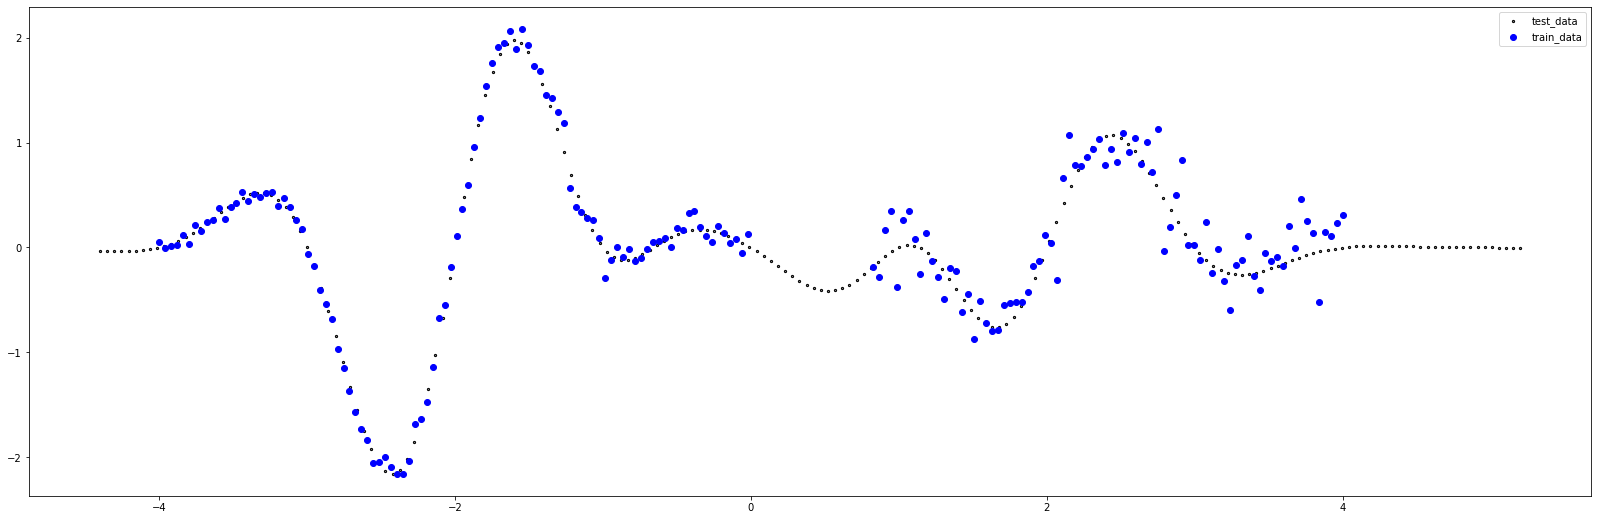

(None, None)

In [ ]:
plot_toy_data(X_train, y_train, X_test_cpu, y_test_cpu), plt.close()

## MLE Model no uq

In [ ]:
det_model = MLP()

# train model
train_model(det_model, torch.nn.MSELoss(), train_loader, lr=1e-2, n_epochs=1000)

# get predictions
y_preds_det = det_model(X_test).detach().cpu()

  0%|          | 0/1000 [00:00<?, ?it/s]

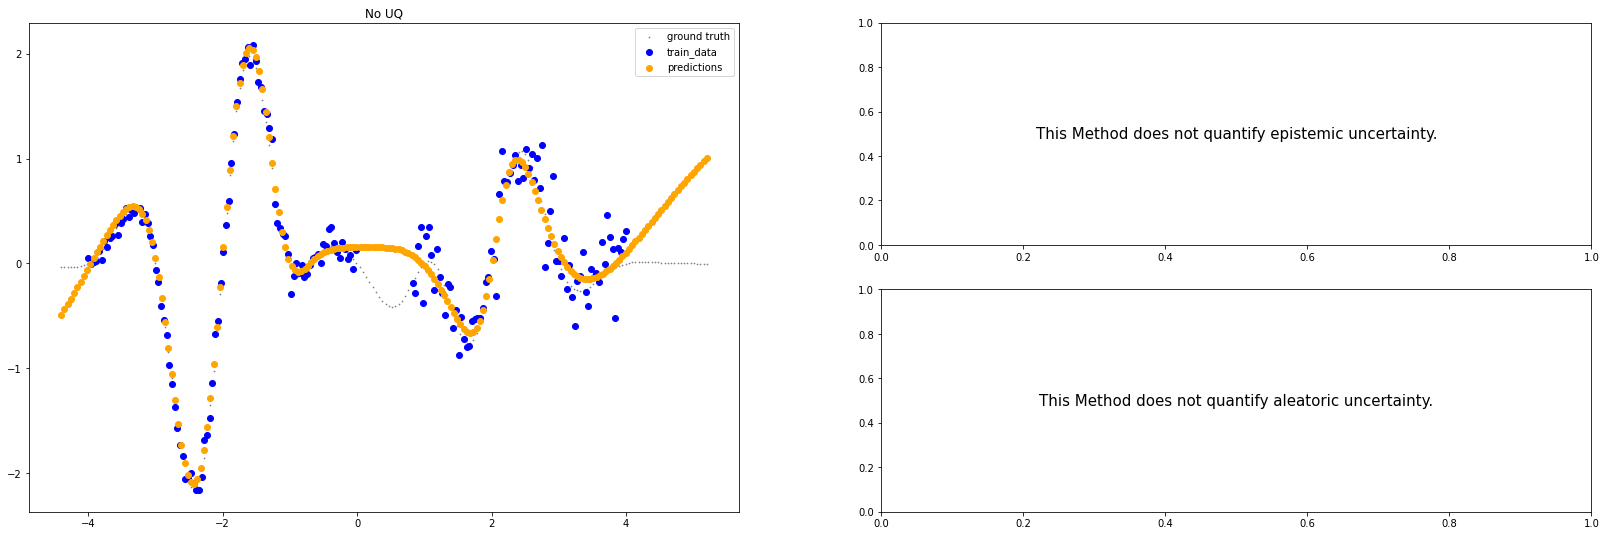

In [ ]:
# plot predictions
plot_predictions(X_train, y_train, X_test_cpu, y_test_cpu, y_preds_det, title="No UQ")

## Deterministic MLP that predicts parameters of Gaussian

In [ ]:
det_uq_model = MLP(n_outputs= 2, n_hidden=[50, 50], predict_sigma=True)

# train model
train_model(det_uq_model, NLL(), train_loader, lr=1e-2, n_epochs=2000)

# get predictions
with torch.no_grad():
  y_preds_det_uq = det_uq_model(X_test).cpu().numpy()

det_uq_mean = y_preds_det_uq[:, 0]
det_uq_std = np.sqrt(y_preds_det_uq[:, 1])
results_dict["deterministic gaussian"] = {"mean": det_uq_mean, "std": det_uq_std}

  0%|          | 0/2000 [00:00<?, ?it/s]

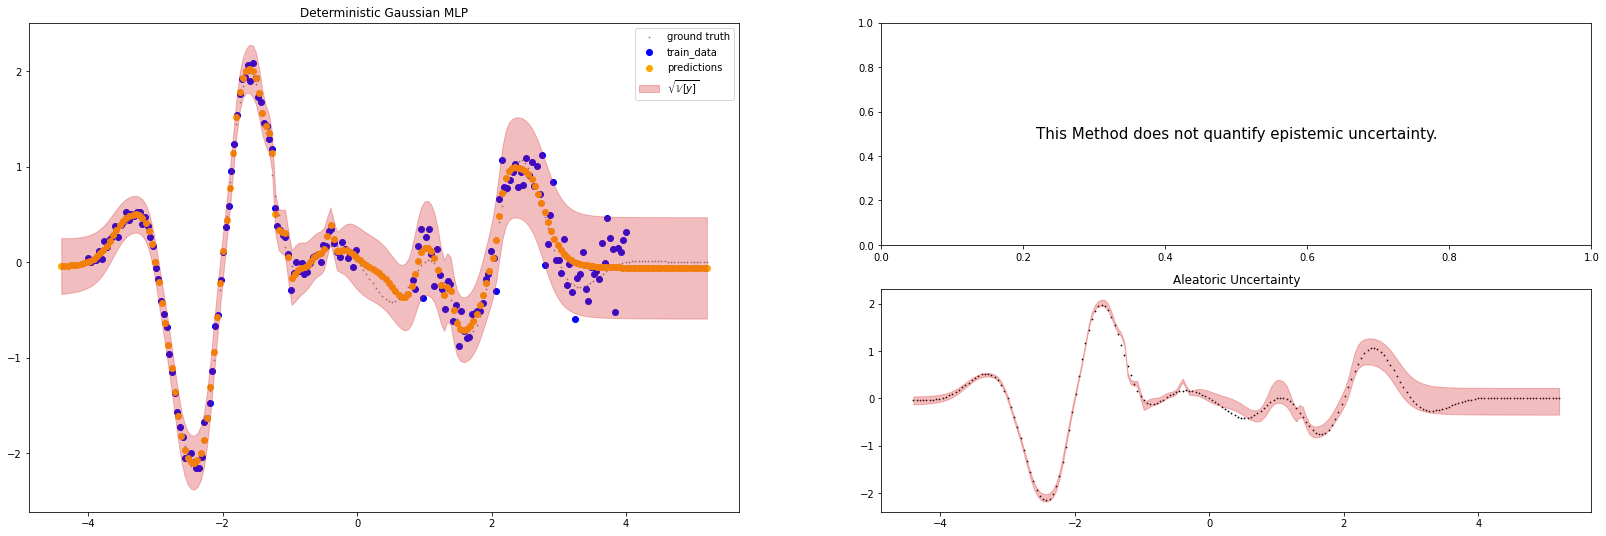

<Figure size 2016x648 with 0 Axes>

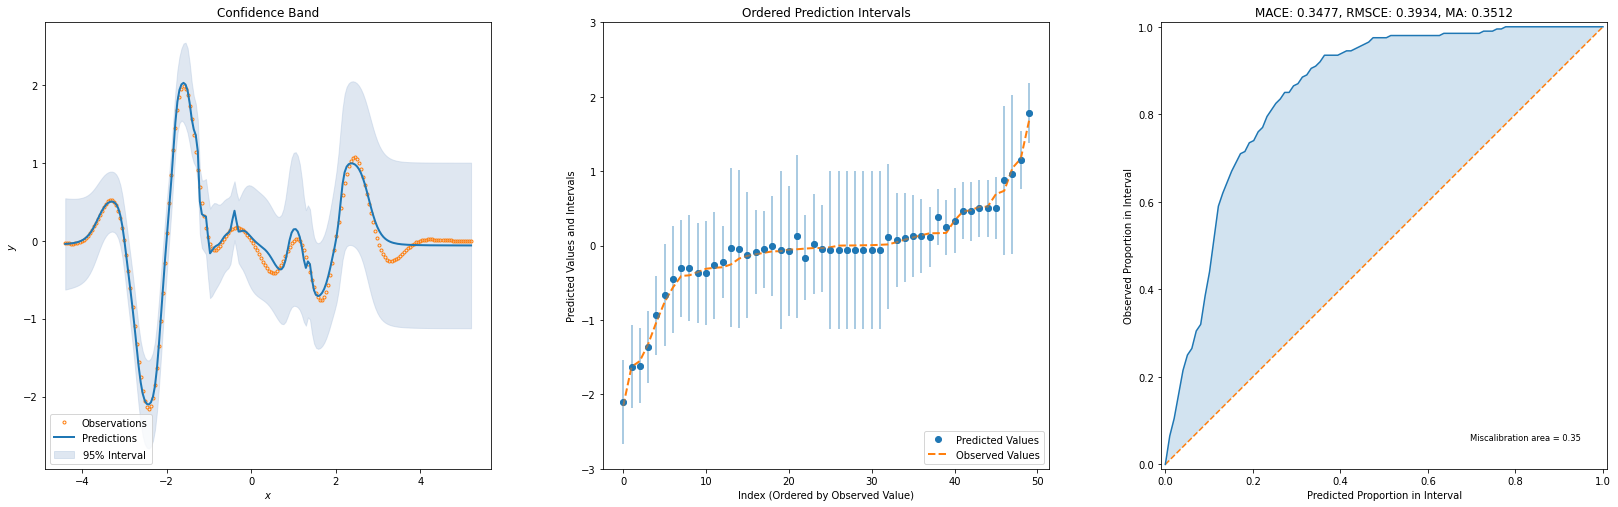

In [ ]:
# plot predictions
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    det_uq_mean,
    det_uq_std,
    aleatoric = y_preds_det_uq[:, 1],
    title="Deterministic Gaussian MLP",
)
plot_calibration_uq_toolbox(det_uq_mean, det_uq_std, y_test_cpu, X_test_cpu)

## MC-Dropout

MC Dropout is presented in [Dropout as a Bayesian Approximation:
Representing Model Uncertainty in Deep Learning](http://proceedings.mlr.press/v48/gal16.pdf) for approximating Baysian Neural Networks is used for uncertainty quantification. In [What Uncertainties Do We Need in Bayesian Deep
Learning for Computer Vision?](https://proceedings.neurips.cc/paper/2017/file/2650d6089a6d640c5e85b2b88265dc2b-Paper.pdf) the approach is extended to include aleatoric uncertainty. 

The following is based on [What Uncertainties Do We Need in Bayesian Deep
Learning for Computer Vision?](https://proceedings.neurips.cc/paper/2017/file/2650d6089a6d640c5e85b2b88265dc2b-Paper.pdf). Here for regression problems the network output is modelled by $f_{\theta}(x) = (\mu_{\theta}(x), \sigma_{\theta}(x))$ where the network is parameterized by weights $\theta$. The network architecture contains a Dropout layer after each hidden layer. This means that the network's weights and biases are modelled as Bernulli distributions, i.e. the weights are dropped, as in set to zero, with probability $p$. The dropout probability is commonly set to $p=0.2$, but can also be optimized. Note that dropout has also been used for regularization, for example in [Learning Deep Networks from Noisy Labels with Dropout Regularization](https://ieeexplore.ieee.org/abstract/document/7837934).

The loss objective, the loss for batch size $m=1$, is chosen to be the negative log-likelihood of a Gaussian,

$-\log(p_{\theta}(y|x))=\frac{(y-\mu_{\theta}(x))^2}{2\sigma_{\theta}(x)^2}+\frac{\log(\sigma_{\theta}(x)^2)}{2}+\text{const.}$

This means that the likelihood of predicting $y$ given an input $x$ is maximized. Note that when SGD is used the constant can be omitted as the parameters are updated by the learning rate times the gradient of the loss. Hence, the constant vanishes. 

In order to obtain a predictive mean and uncertainty, Dropout is activated not only during training, but also at test time. This means that $M$ forward passes yield $M$ different outputs, as the weights are set to zero with probability $p$.

Then, the mean of the $M$ forward passes can be computed as,

$\mu^*(x) = M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x),$

and the variance can be approximated as,

$\sigma^*(x)^2 \approx M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x)^2 - \mu^*(x)^2+ M^{-1} \sum_{i=1}^M \sigma_{\theta_i}(x)^2.$

The epistemic uncertainty is given by the variance of the model predictions,

$\sigma^*_{\textit{m}}(x)^2 \approx M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x)^2 - \mu^*(x)^2.$

The aleatoric uncertainty is given by the mean of the variances predictions,

$\sigma^*_{\textit{d}}(x)^2 \approx M^{-1} \sum_{i=1}^M \sigma_{\theta_i}(x)^2.$

Note that there has been an on-going discussion about the interpretation of MC Dropout as a Baysian Method and, further, its meaningfulness to quantify uncertainty, [Risk versus Uncertainty in Deep Learning:
Bayes, Bootstrap and the Dangers of Dropout](http://bayesiandeeplearning.org/2016/papers/BDL_4.pdf). Moreover, some authors have claimed that MC Dropout is inherently not a Baysian method, [Variational Gaussian Dropout is not Bayesian](http://bayesiandeeplearning.org/2017/papers/45.pdf).

**_Experiments:_** Here are some suggestions that you can try to observe possible changes on the predictive uncertainty. 
- adjust the *dropout_p* parameter 
- adjust the *n_hidden* parameter 
- adjust the *num_samples* variable

### Minimizing MSE single output 

In [ ]:
model_mc_dropout = MLP(dropout_p=0.1, n_hidden=[50, 50, 50])

# train model
train_model(model_mc_dropout, torch.nn.MSELoss(), train_loader, lr=1e-2, n_epochs=2000)

# get predictions
num_samples = 100
with torch.no_grad():
  mc_preds_mse = np.stack(
      [model_mc_dropout(X_test).cpu().numpy() for i in range(num_samples)], axis=2
  ).squeeze(1)
mc_mean_mse = mc_preds_mse.mean(axis=1)
mc_var_mse = mc_preds_mse.var(axis=1)
mc_std_mse = np.sqrt(mc_var_mse.squeeze())

results_dict["mc-dropout"] = {"mean": mc_mean_mse, "std": mc_std_mse}

  0%|          | 0/2000 [00:00<?, ?it/s]

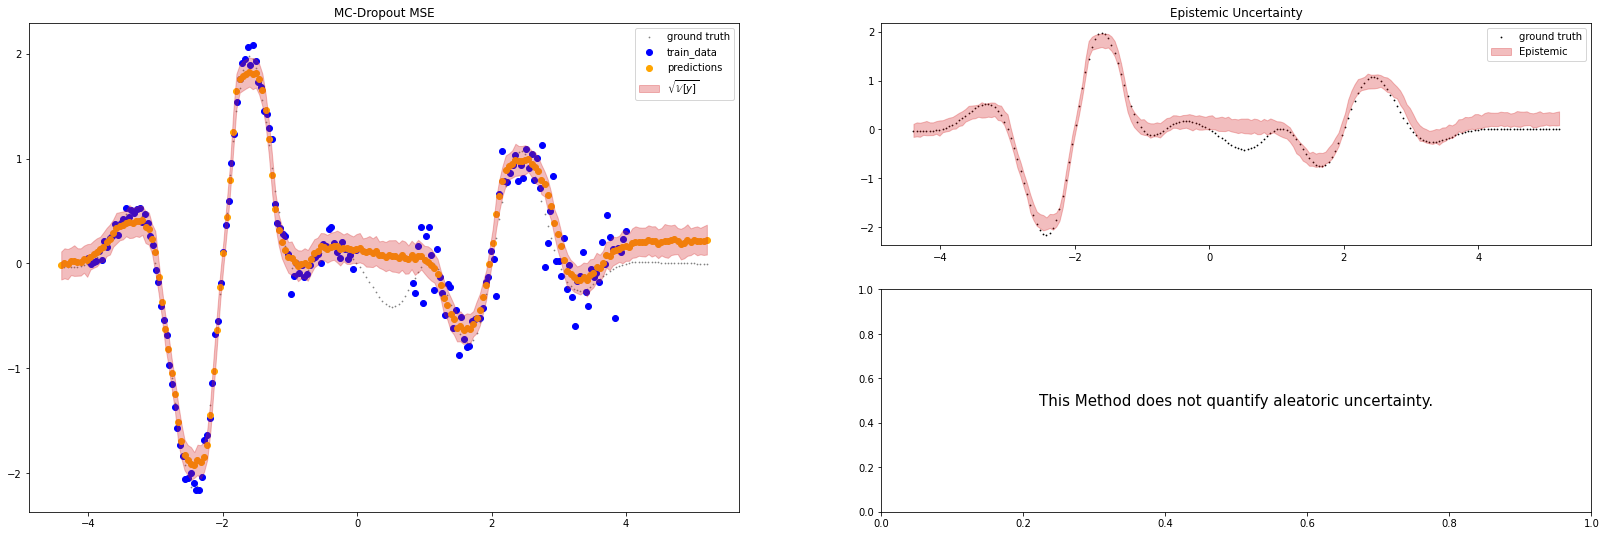

<Figure size 2016x648 with 0 Axes>

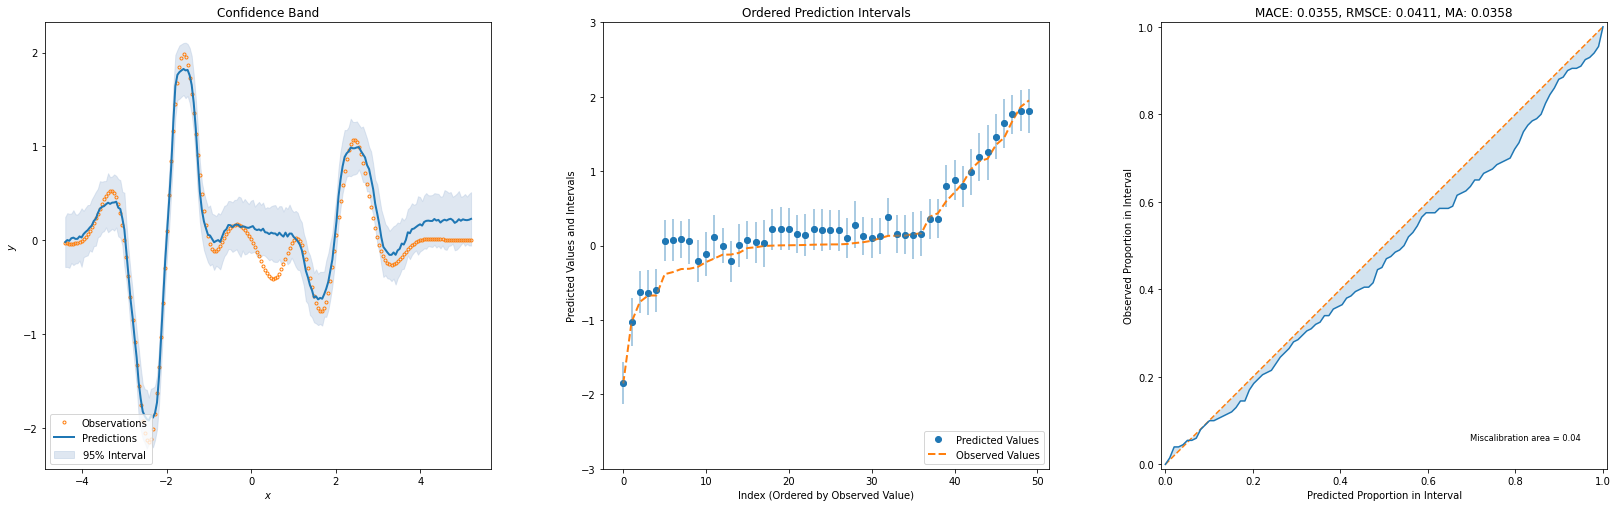

In [ ]:
plot_predictions(X_train, y_train, X_test_cpu, y_test_cpu, mc_mean_mse, mc_std_mse, epistemic=compute_epistemic_uncertainty(mc_preds_mse), title="MC-Dropout MSE")
plot_calibration_uq_toolbox(mc_mean_mse, mc_std_mse, y_test_cpu, X_test_cpu)

### Minimizing Negative Log Likelihood with sigma

In [ ]:
model_mc_dropout_nll = MLP(n_outputs=2, dropout_p=0.1, n_hidden=[50, 50, 50], predict_sigma=True)
# train model
train_model(model_mc_dropout_nll, NLL(), train_loader, lr=1e-2, n_epochs=2000)

# get predictions
num_samples = 100
with torch.no_grad():
  mc_preds_nll = np.stack(
      [model_mc_dropout_nll(X_test).cpu().numpy() for i in range(num_samples)], axis=2
  )

mc_mean_nll = mc_preds_nll[:, 0, :].mean(axis=1)

mc_std_nll = compute_predictive_uncertainty(mc_preds_nll[:, 0, :], mc_preds_nll[:, 1, :])

results_dict["mc-dropout"] = {"mean": mc_mean_nll, "std": mc_std_nll}

  0%|          | 0/2000 [00:00<?, ?it/s]

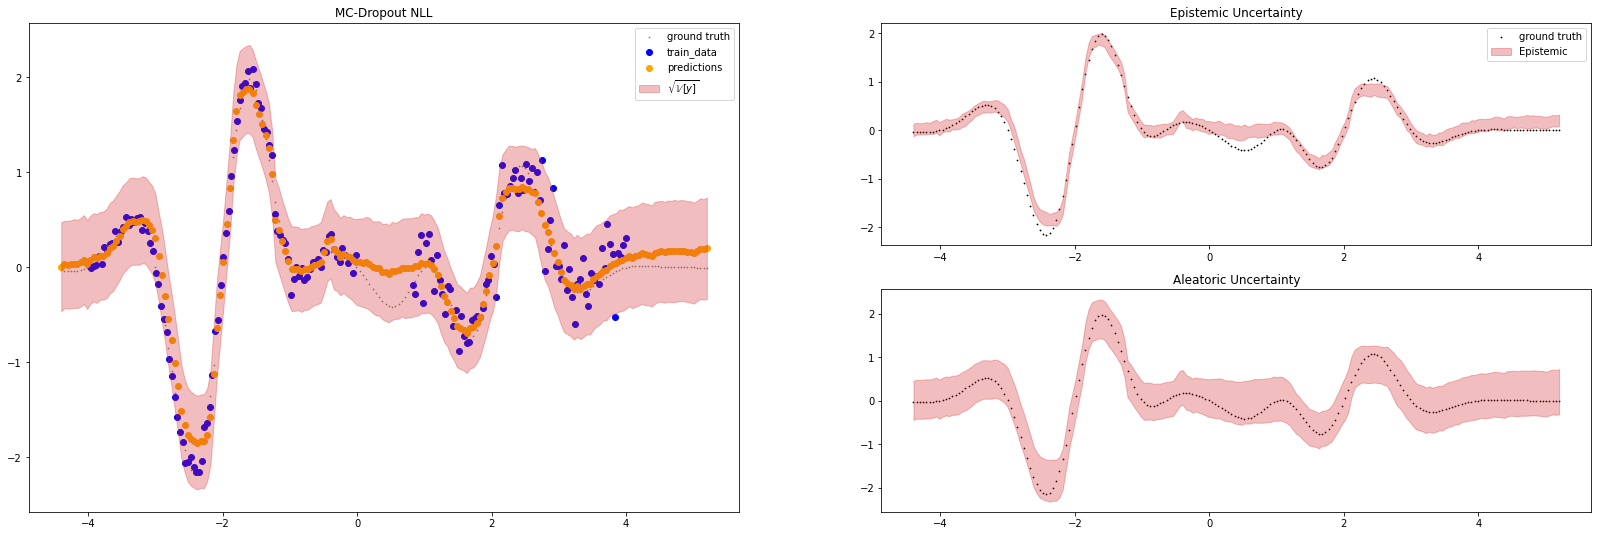

<Figure size 2016x648 with 0 Axes>

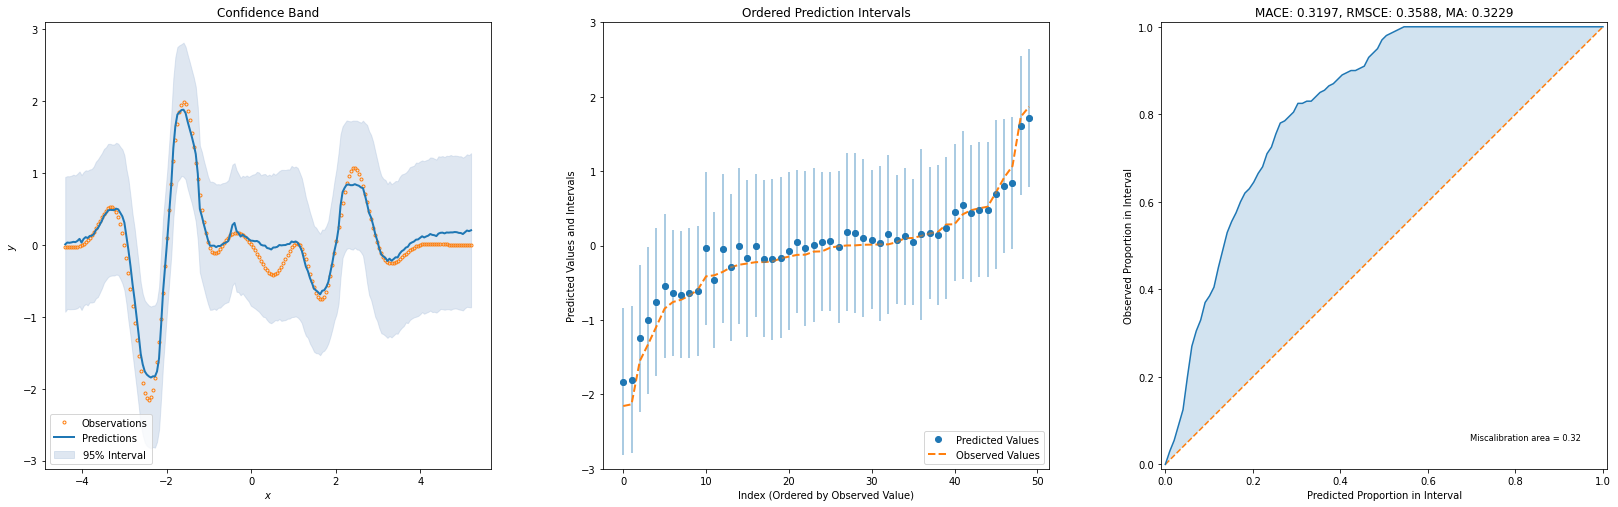

In [ ]:
plot_predictions(X_train, y_train, X_test_cpu, y_test_cpu, mc_mean_nll, mc_std_nll, epistemic=compute_epistemic_uncertainty(mc_preds_nll[:, 0, :]), aleatoric=compute_aleatoric_uncertainty(mc_preds_nll[:, 1, :]), title="MC-Dropout NLL")
plot_calibration_uq_toolbox(mc_mean_nll, mc_std_nll, y_test_cpu, X_test_cpu)

## Deep Ensemble

Deep Ensembles are proposed as an alternative to Baysian Neural Networks in [Simple and Scalable Predictive Uncertainty
Estimation using Deep Ensembles](https://proceedings.neurips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf). Through combining the outputs of multiple networks predictive uncertainty and a mean prediction can be obtained. 

The Network output is modelled by $f_{\theta}(x) = (\mu_{\theta}(x), \sigma_{\theta}(x))$ where the network is parameterized by weights $\theta$. Then, the mean and variance are interpreted as parameters of a Gaussian 

$p_{\theta}(y|x)=\frac{1}{\sqrt{2\pi\sigma_{\theta}(x)^2}}\exp\big(\frac{(y-\mu_{\theta}(x))^2}{2\sigma_{\theta}(x)^2}\big).$

The loss objective, the loss for batch size $m=1$, is chosen to be the negative log-likelihood of a Gaussian,

$-\log(p_{\theta}(y|x))=\frac{(y-\mu_{\theta}(x))^2}{2\sigma_{\theta}(x)^2}+\frac{\log(\sigma_{\theta}(x)^2)}{2}+\text{const.}$

This means that the likelihood of predicting $y$ given an input $x$ is maximized. Note that when SGD is used the constant can be omitted as the parameters are updated by the learning rate times the gradient of the loss. Hence, the constant vanishes. 

In order to combine the outputs of multiple networks, $M$ networks are trained. As we modelled the output of one network as a Gaussian, now the outputs of $M$ networks are modelled as a Gaussian mixture,

$p_{\theta}(y|x) = M^{-1} \sum_{i=1}^M \mathcal{N}(\mu_{\theta_i}(x), \sigma_{\theta_i}(x)^2).$

Then, the mean of the deep ensemble can be computed as,

$\mu^*(x) = M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x),$

and the variance as,

$\sigma^*(x)^2 = M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x)^2 - \mu^*(x)^2+ M^{-1} \sum_{i=1}^M \sigma_{\theta_i}(x)^2.$

The epistemic uncertainty is given by the variance of the model predictions,

$\sigma^*_{\textit{m}}(x)^2 = M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x)^2 - \mu^*(x)^2.$

The aleatoric uncertainty is given by the mean of the variances predictions,

$\sigma^*_{\textit{d}}(x)^2 = M^{-1} \sum_{i=1}^M \sigma_{\theta_i}(x)^2.$

**_Experiments:_** Here are some suggestions that you can try to observe possible changes on the predictive uncertainty. 
- adjust the number of ensemble members *n_ensembles*
- adjust the model capacity of the individual model members when instantiating *MLP()*

### A naive implementation with minimizing MSE loss single output

In [ ]:
n_ensembles = 5

trained_models = []
for i in range(n_ensembles):
    ensemble_member = MLP()
    trained_models.append(
        train_model(ensemble_member, torch.nn.MSELoss(), train_loader, lr=1e-2, n_epochs=1000)
    )

# get predictions
mse_de_preds = torch.stack(
    [member(X_test).detach().cpu() for member in trained_models], dim=2
).squeeze(1)
mse_de_mean = mse_de_preds.mean(dim=1).numpy()
mse_de_var = mse_de_preds.var(dim=1)
mse_de_std = mse_de_var.squeeze().sqrt().cpu().numpy()

results_dict["naive_deep_ensemble"] = {"mean": mse_de_mean, "std": mse_de_std}

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

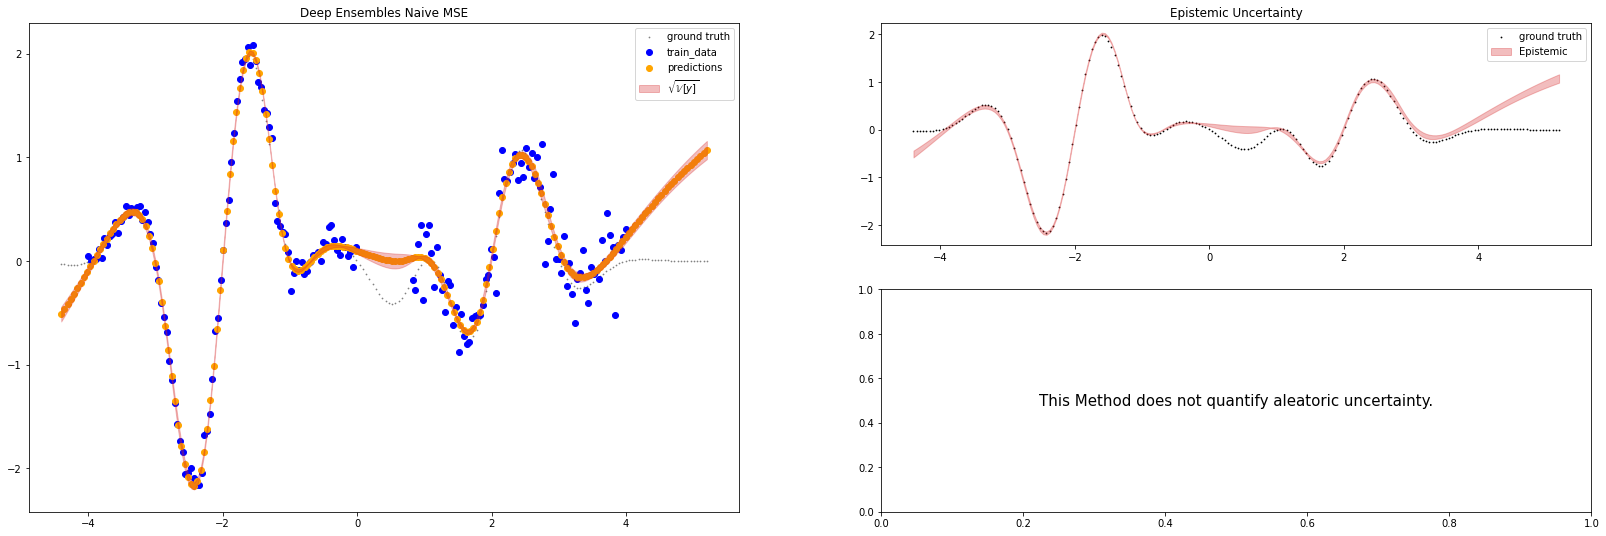

<Figure size 2016x648 with 0 Axes>

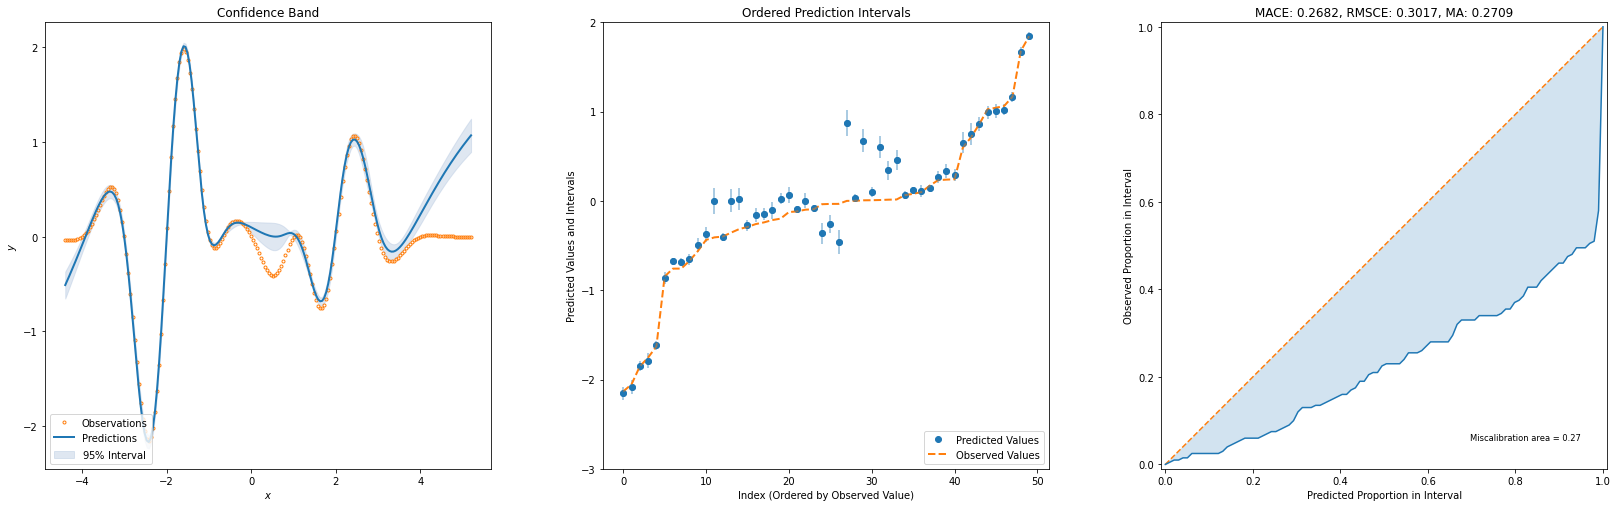

In [ ]:
plot_predictions(
    X_train, y_train, X_test_cpu, y_test_cpu, mse_de_mean, mse_de_std, epistemic=mse_de_std, title="Deep Ensembles Naive MSE"
)
plot_calibration_uq_toolbox(mse_de_mean, mse_de_std, y_test_cpu, X_test_cpu)

### Minimizing Negative Log Likelihood with sigma

In [ ]:
trained_models = []
for i in range(n_ensembles):
    ensemble_member = MLP(n_outputs=2, n_hidden=[50, 50, 50], predict_sigma=True)
    trained_models.append(
        train_model(ensemble_member, NLL(), train_loader, lr=1e-2, n_epochs=2000)
    )

# get predictions
with torch.no_grad():
  nll_de_preds = np.stack(
      [member(X_test).cpu().numpy() for member in trained_models], axis=2
  )# shape N, 2, num_ensemble_members
nll_de_mean = nll_de_preds[:, 0, :].mean(axis=1)
# nll_de_std = nll_de_preds[:, 1, :].mean(dim=1)
nll_de_std = compute_predictive_uncertainty(nll_de_preds[:, 0, :], nll_de_preds[:, 1, :])

results_dict["nll_deep_ensemble"] = {"mean": nll_de_mean, "std": nll_de_std}

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

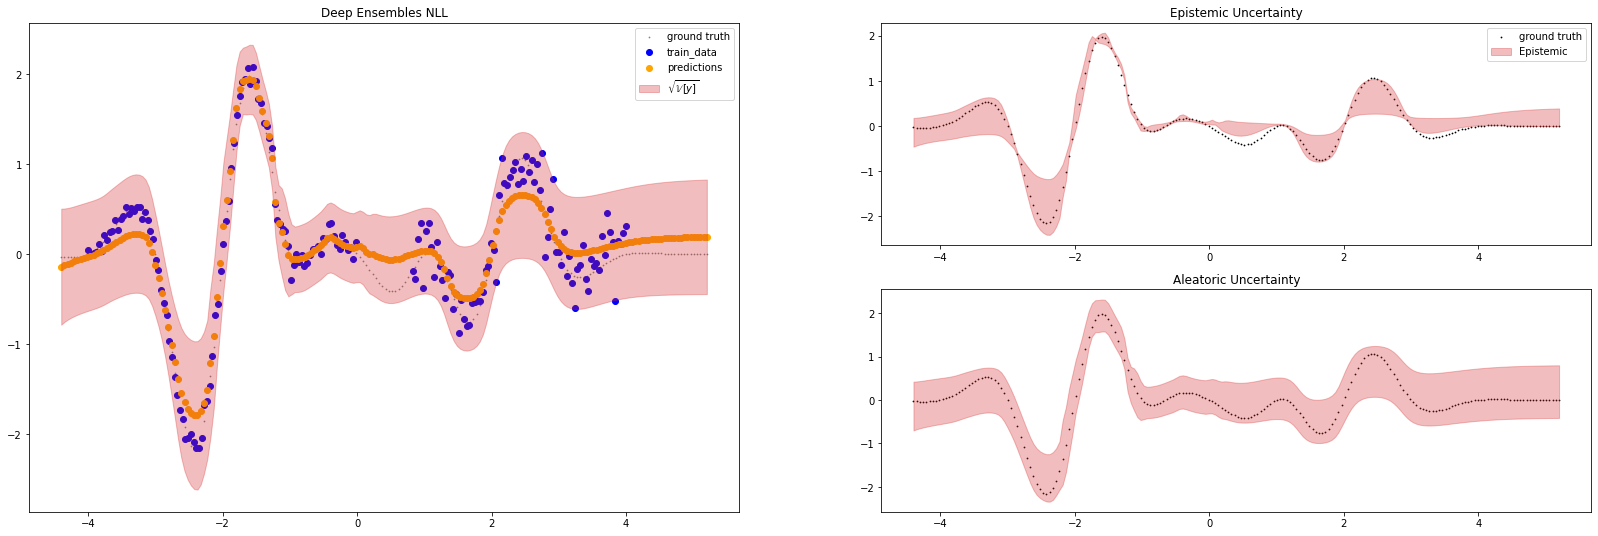

<Figure size 2016x648 with 0 Axes>

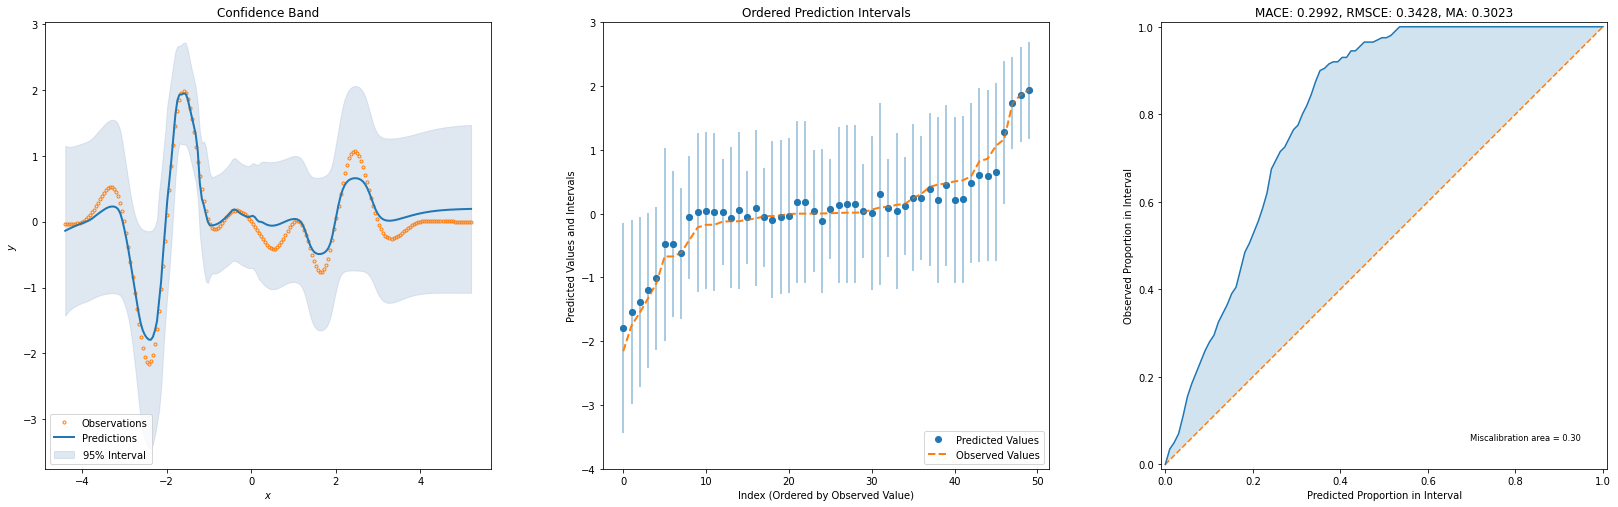

In [ ]:
plot_predictions(
    X_train, y_train, X_test_cpu, y_test_cpu, nll_de_mean, nll_de_std, epistemic=compute_epistemic_uncertainty(nll_de_preds[:, 0, :]), aleatoric=compute_aleatoric_uncertainty(nll_de_preds[:, 1, :]), title="Deep Ensembles NLL"
)
plot_calibration_uq_toolbox(nll_de_mean, nll_de_std, y_test_cpu, X_test_cpu)

## Laplace Approximation




The Laplace Approximation (LA) is a Bayesian method that allows trained models to express epistemic uncertainty. It was made popular by David MacKay's 1992 [paper](https://authors.library.caltech.edu/13793/1/MACnc92b.pdf) titled "A Practical Bayesian Framework for Backpropagation Networks". 

In this setting, we define a prior distribution $p(\theta)$ over our network parameters. Because modern neural networks consists of millions of parameters, obtaining a posterior distribution over the weights $\theta$ is intractable. The LA

"[...] locally approximates the posterior with
a Gaussian distribution centered at a local maximum, with covariance matrix corresponding to the
local curvature. Two key advantages of the LA are that the local maximum is readily available from
standard maximum a posteriori (MAP) training of NNs, and that curvature estimates can be easily and
efficiently obtained thanks to recent advances in second-order optimization, both in terms of more
efficient approximations to the Hessian[...]" [Laplace Redux – Effortless Bayesian Deep Learning](https://arxiv.org/pdf/2106.14806.pdf).

Summarizing the above, the idea of the Laplace Approximation is to take the obtained MAP estimate of the parameters $\theta$ from a trained network $f_{\theta}(x) = \mu_{\theta}(x)$ and construct a Gaussian distribution around it. 

Here $\theta_{MAP} = \text{argmin} \mathcal{L}(\theta; \mathcal{D}),$
where in our case $\mathcal{L}(\theta; \mathcal{D}) := -\sum_{i=1}^n log(p(y_i|f_{\theta}(x_i)))$ and we chose the posterior $p(y_i|f_{\theta}(x_i))$ to be a Gaussian such that the loss is the mean squared error. Hence, we can use our deterministic MLP trained earlier with the MSE loss.

To do this we use, Bayes Theorem, as in  [Laplace Redux – Effortless Bayesian Deep Learning](https://arxiv.org/pdf/2106.14806.pdf), to get 

$p(\theta|D) = p(D\vert\theta)p(\theta)/p(D)= \frac{1}{Z} exp(- \mathcal{L}(\theta; D))$, 

with $Z = \int p(D\vert\theta)p(\theta) d\theta$. 

We now use a second-order expansion of $\mathcal{L}$ around $\theta_{MAP}$ to construct a Gaussian approximation to the posterior $p(\theta|D)$:

$-\mathcal{L}(\theta; D) \approx -\mathcal{L}(\theta_{MAP}; D)- \frac{1}{2}(\theta-\theta_{MAP}) (\nabla_{\theta}^2 \mathcal{L}(\theta; D)\vert \theta_{MAP}) (\theta-\theta_{MAP}).$

The term with the first order derivative is zero as the loss is evaluated at a minimum $\theta_{MAP}$ ([Probabilistic Machine Learning, Murphy](https://probml.github.io/pml-book/book2.html)), and, further, one assumes that the first term is neglible as the loss is evaluated at $\theta = \theta_{MAP}$. Then taking the expontential of both sides allows to identify, after normalization, the Laplace approximation,

\begin{align*}
p(\theta|D) \approx \mathcal{N}(\theta_{MAP}, \Sigma) && \Sigma =  (\nabla_{\theta}^2 \mathcal{L}(\theta; D)\vert \theta_{MAP})^{-1}.
\end{align*}

With the definition of Gaussian distributions, we can write the above:

$p(\theta|D) \approx \frac{1}{(2\pi)^{W/2}}\frac{1}{|\Sigma|^{-1/2}}\exp{-\frac{1}{2}(x-\theta_{MAP})^T \Sigma^{-1} (x-\theta_{MAP})}$

And noting that the covariance is just the inverse Hessian of the loss, 

$\Sigma =  (\nabla_{\theta}^2 \mathcal{L}(\theta; D)\vert \theta_{MAP})^{-1} = H^{-1}$, 

this gives us:

$p(\theta|D)\approx \mathcal{N}(\theta_{MAP}, H^{-1})$,

 where $\theta_{MAP}\in \mathcal{R}^W$ and $H^{-1}\in \mathcal{R}^{W\times W}$, with $W$ being the number of weights.

The computation of the Hessian term is still expensive. Therefore, further approximations are introduced in practice, most commonly the Generalized Gauss-Newton matrix ([GNN](https://jmlr.org/papers/volume21/17-678/17-678.pdf)).

This takes the following form:
$H \approx \widetilde{H}=\sum_{n=1}^NJ_n^TH_nJ_n$
where $J_n\in \mathcal{R}^{O\times W}$ is the Jacobian of the model outputs with respect to the parameters $\theta$ and $H_n\in\mathcal{R}^{O\times O}$ is the Hessian of the negative log-likelihood with respect to the model outputs. Here $O$ denotes the model output size and $W$ the number of parameters.

\begin{align*}
J_n=\frac{\partial f_{\theta}(x_n)}{\partial \theta} && H_n=\frac{-\partial^2\log(p(y|f_{\theta}(x_n))}{\partial^2 f_{\theta}(x_n)}
\end{align*}

This means, that we do not have to take the full second-order Hessian w.r.t all weights but can approximate it with a method that only requires more computationally cheaper derivatives.

During inference on unseen data, we cannot compute the full posterior predictive distribution but instead resort to sampling to approximate this distribution:
$\frac{1}{S}\sum_{s=1}^S p(y^{\star}|x^{\star}, \theta_s),$

where for each prediction input $x^*$ we make a total of S predictions, each time with a differently sampled parameter vector $\theta \sim p(\theta|D)$. The prediction is then obtained by computing the mean and variance, epistemic uncertainty, of the predictions obtained from the original MLP with S different parameters $\theta$. The mean is given by

$\hat{y}(x^{\star}) = \frac{1}{S} \sum_{s=1}^S f_{\theta_s}(x^{\star}),$

and the squared variance by

$\sigma^2(x^{\star}) = \frac{1}{S} \sum_{s=1}^S f_{\theta_s}(x^{\star})^2 - \hat{y}(x^{\star})^2.$


[Immer et al. 2021](proceedings.mlr.press/v130/immer21a/immer21a.pdf) showed that a linearization of the model achieves better performance in practice:
$f_{\theta}(x)=f_{\theta_{MAP}}(x)+ J_{\theta_{MAP}}(\theta-\theta_{MAP})$

[Daxberger et al. 2020](https://arxiv.org/abs/2010.14689) introduced a subnetwork selection strategy that turns selected weights "Bayesian" while keeping the rest of the network deterministic and show performance on par with deep ensembles.



**_Experiments:_** Here are some suggestions that you can try to observe possible changes on the predictive uncertainty. The documentation for the Laplace class can be found [here](https://aleximmer.github.io/Laplace/#laplace.BaseLaplace)
- adjust the default *prior_mean*
- adjust the default *prior_precision*, the defition of precision is $\frac{1}{variance}$
- adjust the *hessian_structure* and/or *subset_of_weights* ([documentation](https://aleximmer.github.io/Laplace/#laplace.Laplace))

In [ ]:
# take the deterministic model we trained and fit laplace
la = Laplace(det_model.net, "regression", prior_mean=0, prior_precision=1, subset_of_weights="all", hessian_structure="full")
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(
    1, requires_grad=True
)

After fitting the Laplace Approximation the prior precision can be tuned via Empirical Bayes by optimizing the marginal log likelihood. Internally, the *sigma_noise* parameter is tuned. You can test the effect by commenting out the next cell to see the difference.

In [ ]:
 # tune the prior precision via Empirical Bayes
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [ ]:
x = X_test.flatten().cpu().numpy()
laplace_mean, laplace_var = la(X_test)
laplace_mean = laplace_mean.squeeze().detach().cpu().numpy()
laplace_epistemic = laplace_var.squeeze().sqrt().cpu().numpy()
laplace_aleatoric = la.sigma_noise.item()
laplace_predictive = np.sqrt(laplace_epistemic**2 + la.sigma_noise.item() ** 2)

results_dict["laplace"] = {"mean": laplace_mean, "std": laplace_predictive}

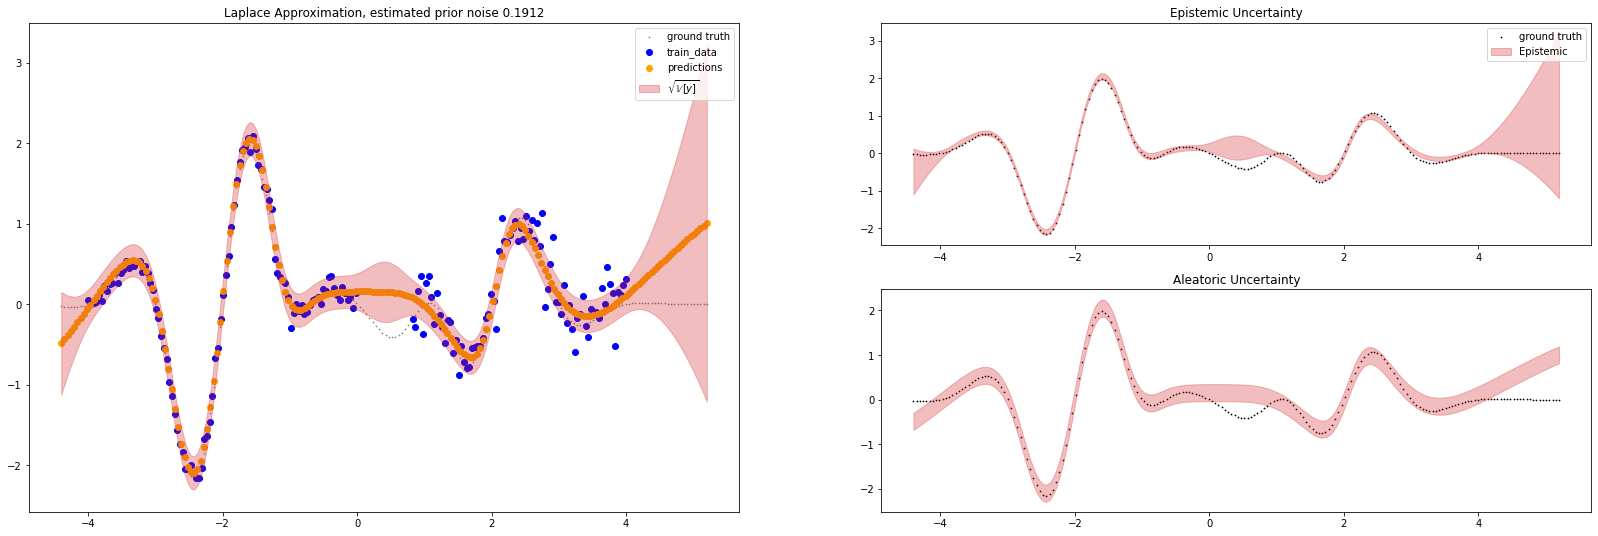

<Figure size 2016x648 with 0 Axes>

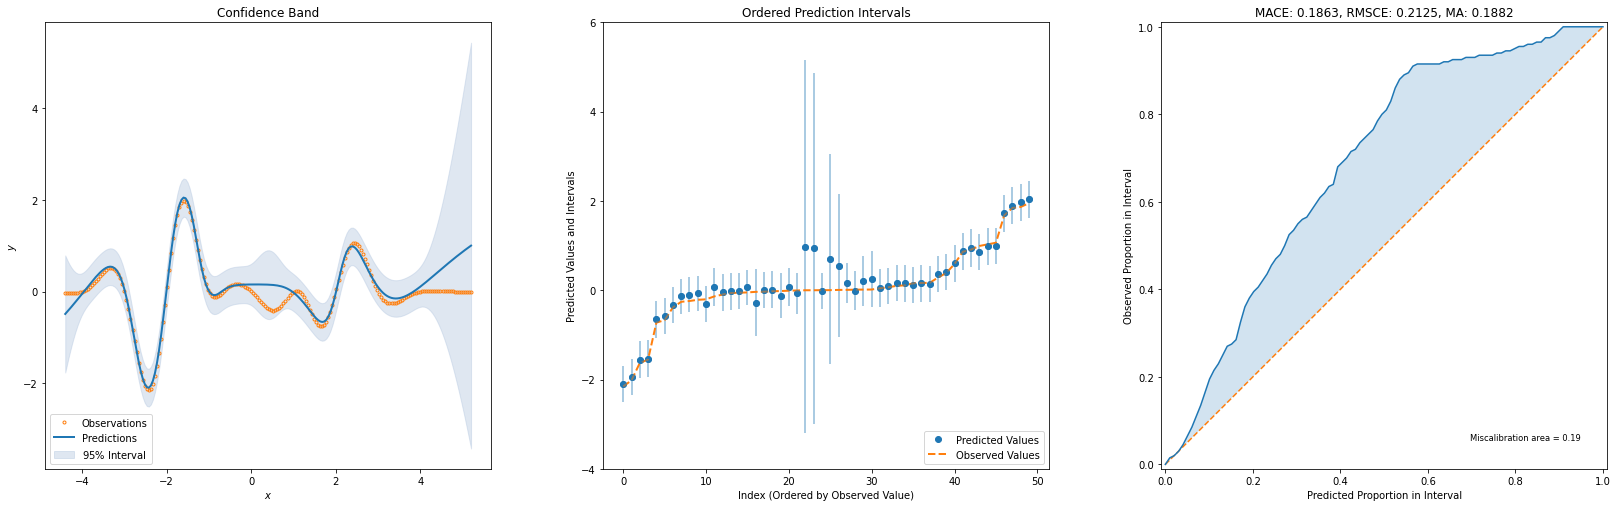

In [ ]:
plot_predictions(
    X_train, y_train, X_test_cpu, y_test_cpu, laplace_mean, laplace_predictive, epistemic=laplace_epistemic, aleatoric=laplace_aleatoric, title=f"Laplace Approximation, estimated prior noise {la.sigma_noise.item():.4f}"
)
plot_calibration_uq_toolbox(laplace_mean, laplace_predictive, y_test_cpu, X_test_cpu)

## Quantile Regression


The goal of Quantile Regression is to extend a standard regression model to also predict conditional quantiles that approximate the true quantiles of the data at hand. It does not make assumptions about the distribution of errors as is usually common. It is a more commonly used method in Econometrics and Time-series forecasting.

In the following we will describe univariate quantile regression. Any chosen conditional quantile $α \in [0,1]$ can be defined as $q_\alpha(x):=\text{inf}\{y \in \mathbb{R}: F(y \vert X = x ) \geq \alpha\}$ where $F(y \vert X = x)=P(Y\leq y\vert X = x)$ is a strictly monotonic increasing cumulative density function.


Given a neural network $f$ parameterized by $\theta$, we would configure the number of outputs to be equivalent to the number of quantiles we want to predict. This means that, if we want to predict $n$ quantiles $[q_1, ... q_n]$, $f_{\theta}(x) = (\hat{y}_1, ...,\hat{y}_n)$. The model is subsequently trained by minimizing the pinball loss function ([Koenker and Basset 1978](https://www.jstor.org/stable/1913643)).


The Pinball Loss, or also called Quantiles Loss, for a given quantile $q_i \in [q_1, ... q_n]$ is then defined as follows:
 $\mathcal{L}(y_i, \hat{y}_i, q_i)=\max(q_i (y_i - \hat{y}_i), (1-q_i)(y_i-\hat{y}_i))$

where $y_i$ is the true target and $\hat{y}_i$ is the model output. While one does not actually know the true quanitles, the loss yields an approximation to these
them. To see this, consider setting $q=\frac{1}{2}$, then this loss is equal to the Mean Absolute Error, which is minimized by predicting the median. For an explanation of the pinball loss function you can checkout this [blog post](https://towardsdatascience.com/probabilistic-forecasts-pinball-loss-function-baf86a5a14d0). 

During inference, the model will output an estimate for your chosen quantiles and these can be used as an indication of aleatoric uncertainty.

**_Experiments:_** Here are some suggestions that you can try to observe possible changes on the predictive uncertainty.
- adjust the quantiles you optimize for (we assume that at least the 0.5 quantile is included), but what happens on the lower and upper quantile?
- the effect of model capacity in *MLP()*

In [ ]:
#choose quantiles that you want to predict, note that for the plot you need to include the 0.5 quantile
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

#create MLP with the number of outputs equal to the number of quantiles
quantile_model = MLP(
    n_hidden=[50, 50, 50], n_outputs=len(quantiles)
)

#train with mysterious QuantileLossAlt()
quantile_model = train_model(
    quantile_model, QuantileLoss(quantiles), train_loader, lr=1e-2, n_epochs=600
)

#get quantile predictions
with torch.no_grad():
  quantile_preds = quantile_model(X_test).cpu().numpy()

#get median prediction, by only predicting the 0.5 quantile
quantile_median = quantile_preds[:, quantiles.index(0.5)]

#get mean and standard deviation to compare quantile regression to other UQ methods
q_model_mean, q_model_std = compute_sample_mean_std_from_quantile(quantile_preds, quantiles)

# due to overlapping quantiles
q_model_std[q_model_std <=0]=1e-6

results_dict["quantile_reg"] = {"mean": q_model_mean, "std": q_model_std} # in some cases the quantiles overlap

  0%|          | 0/600 [00:00<?, ?it/s]

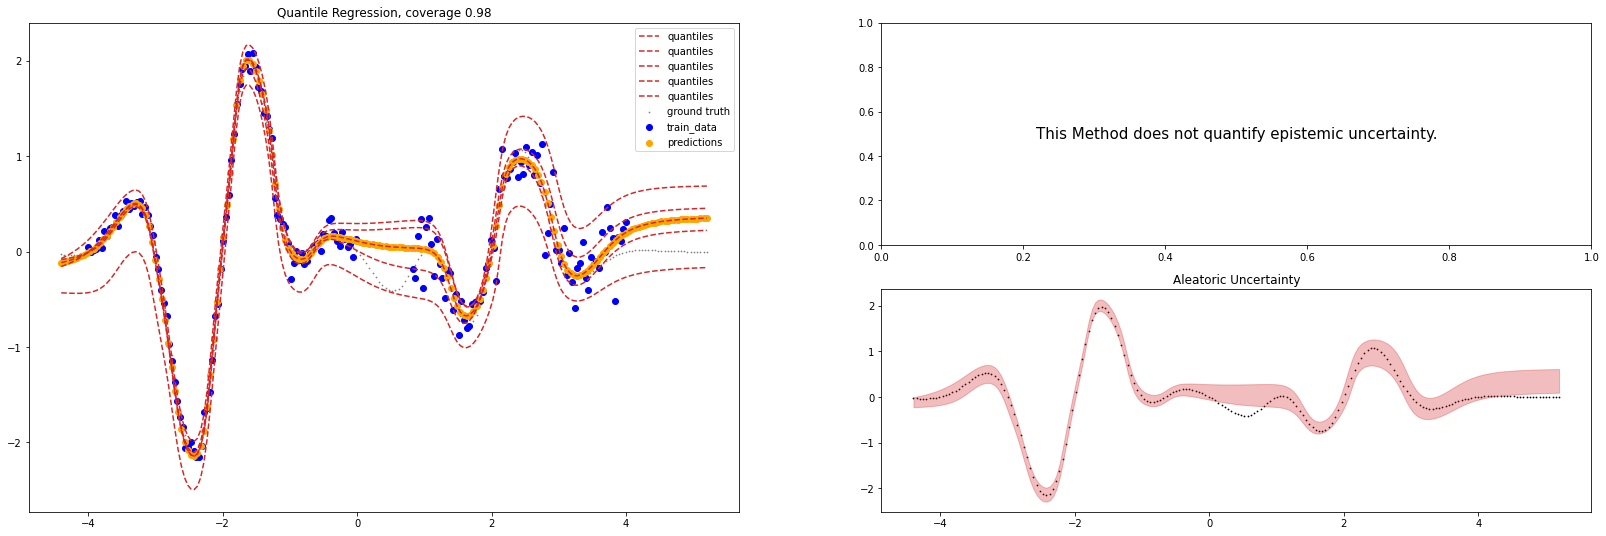

<Figure size 2016x648 with 0 Axes>

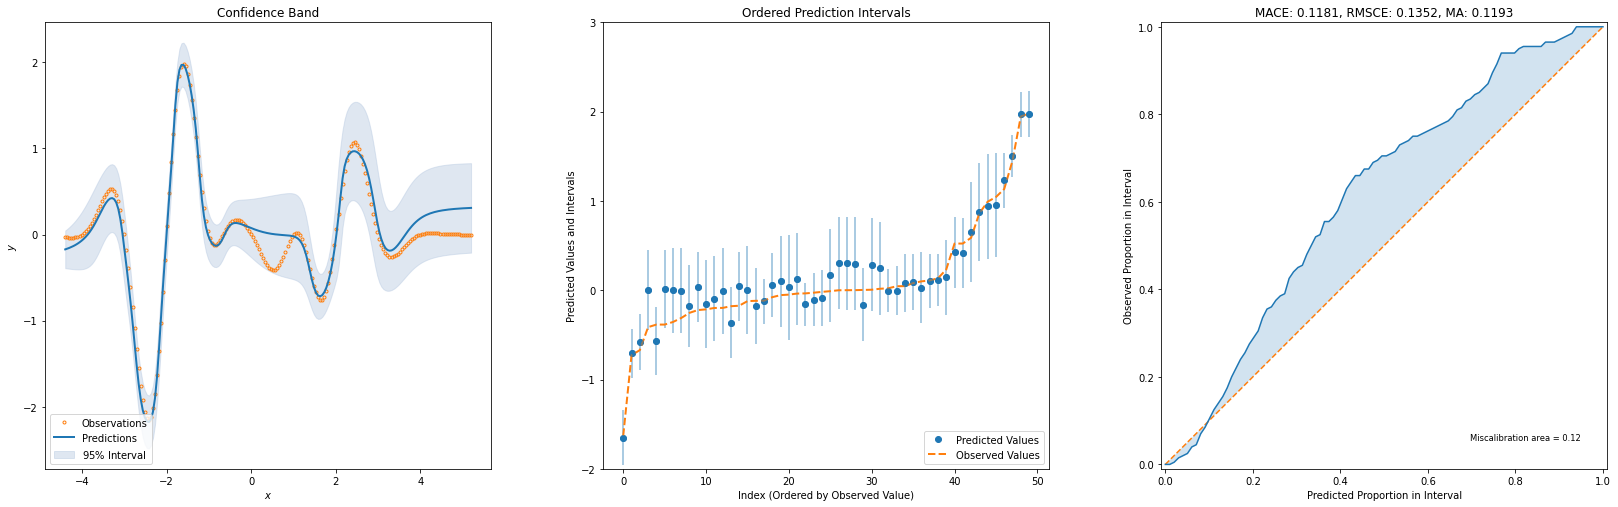

In [ ]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    quantile_median,
    pred_quantiles=quantile_preds,
    aleatoric=q_model_std,
    title=f"Quantile Regression, coverage {compute_empirical_coverage(quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(q_model_mean, q_model_std, y_test_cpu, X_test_cpu)

## Conformal Prediction

**_NOTE:_** In the current setup we follow the Conformal Prediction Tutorial linked below, where they apply Conformal Prediction to Quantile Regression. However, Conformal Prediction is a more general statistical framework and model-agnostic in the sense that whatever Frequentist or Bayesian approach one might take, Conformal Prediction can be applied to calibrate your predictive uncertainty bands.

Conformalize the quantile regression model. From Chapter 2.2 of [Gentle Intro to Conformal Prediction](https://people.eecs.berkeley.edu/~angelopoulos/publications/downloads/gentle_intro_conformal_dfuq.pdf). 

1. Identify a heuristic notion of uncertainty for our problem and use it to construct a scoring function, where large scores imply a worse fit between inputs $X$ and scalar output $y$. In the regression case, it is recommended to use a quantile loss that is then adjusted for prediction time via the conformal prediction method. 
2. Compute the Score function output for all data points in your held out validation set and compute a desired quantile $\hat{q}$ across those scores.
3. Conformalize your quantile regression bands with the computed $\hat{q}$. The prediction set for an unseen test point $x_{\star}$ is now $T(x_{\star})=[\hat{y}_{\alpha/2}(x_{\star})-\hat{q}, \hat{y}_{1-\alpha/2}(x_{\star})+\hat{q}]$ where $\hat{y}_{\alpha/2}(x_{\star})$ is the lower quantile model output and $\hat{y}_{1-\alpha/2}(x_{\star})$ is the upper quantile model output. This means we are adjusting the quantile bands symmetrically on either side and this conformalized prediction interval is guaranteed to satisfy our desired coverage requirement regardless of model choice.

The central assumption conformal prediction makes is exchangeability, which restricts us in the following two ways ([Barber et al. 2022](https://arxiv.org/abs/2202.13415)) :
1. The order of samples does not change the joint probability
   distribution. This is a more general notion to the commonly known i.i.d assumption, meaning that we assume that our data is independently drawn from the same distribution and does not change between the different data splits. In other words, we assume that any permutation of the dataset observations has equal probability.
2. Our modeling procedure is assumed to handle our individual data samples symmetrically to ensure exchangeability beyond observed data. For example a sequence model that weighs more recent samples higher than older samples would violate this assumption, while a classical image classification model that is fixed to simply yield a prediction class for any input image does not. Exchangeability means that if I have all residuals of training and test data, I cannot say from looking at the residuals alone whether a residual belongs to a training or test point. A test point is equally likely to be any of the computed residuals.

The same procedure we implemented above is availalable through the [Fortuna Library](https://github.com/awslabs/fortuna) which among other methods implements Conformal Prediction, more precisly Conformalized Quantile Regression [Romano et al. 2019](https://arxiv.org/abs/1905.03222).

**_Experiments:_** Here are some suggestions that you can try to observe possible changes on the predictive uncertainty.
- observe the changes when changing the error rate through the upper quantile in the *quantiles* variable
- pay attention to the marginal coverage displayed in the chart title

In [ ]:
def conformalize_scores(cal_preds: np.ndarray, cal_labels: np.ndarray, test_preds: np.ndarray, quantiles: List[float]) -> np.ndarray:
  """Implements Conformalized Quantile Regression
  
  Args:
    calib_preds: calibration set predictions
    calib_labels: calibration set targets
    test_preds: test set predictions that will be conformalized predictions
    quantiles: quantiles

  Returns:
    conformalized prediction sets (adjusted quantile bands)
  """
  cal_labels = cal_labels.squeeze()
  alpha = 1 - max(quantiles) # 1-alpha is the desired coverage
  n = cal_labels.shape[0]
  cal_upper = cal_preds[:, -1]
  cal_lower = cal_preds[:, 0]

  # Get scores. cal_upper.shape[0] == cal_lower.shape[0] == n
  cal_scores = np.maximum(cal_labels-cal_upper, cal_lower-cal_labels)

  # Get the score quantile
  qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')

  # Deploy (output=lower and upper adjusted quantiles)
  conformal_prediction_sets = np.stack([cal_lower - qhat, test_preds[:, quantiles.index(0.5)], cal_upper + qhat], axis=1)
  return conformal_prediction_sets


### Conformal Prediction with Quantile Regression

In [ ]:
quantile_cp_sets = conformalize_scores(quantile_preds, y_test_cpu, quantile_preds, quantiles)

cp_qr_model_mean, cp_qr_model_std = compute_sample_mean_std_from_quantile(quantile_cp_sets, quantiles)

results_dict["cp"] = {"mean": cp_qr_model_mean, "std": cp_qr_model_std}

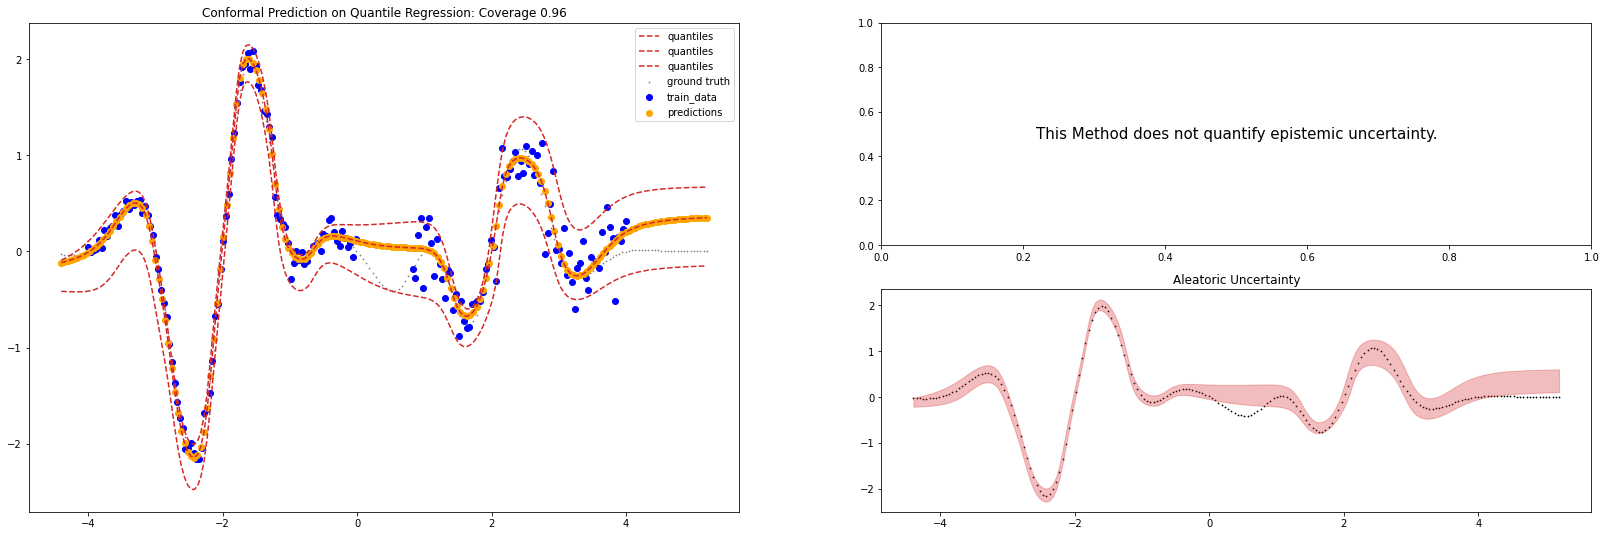

<Figure size 2016x648 with 0 Axes>

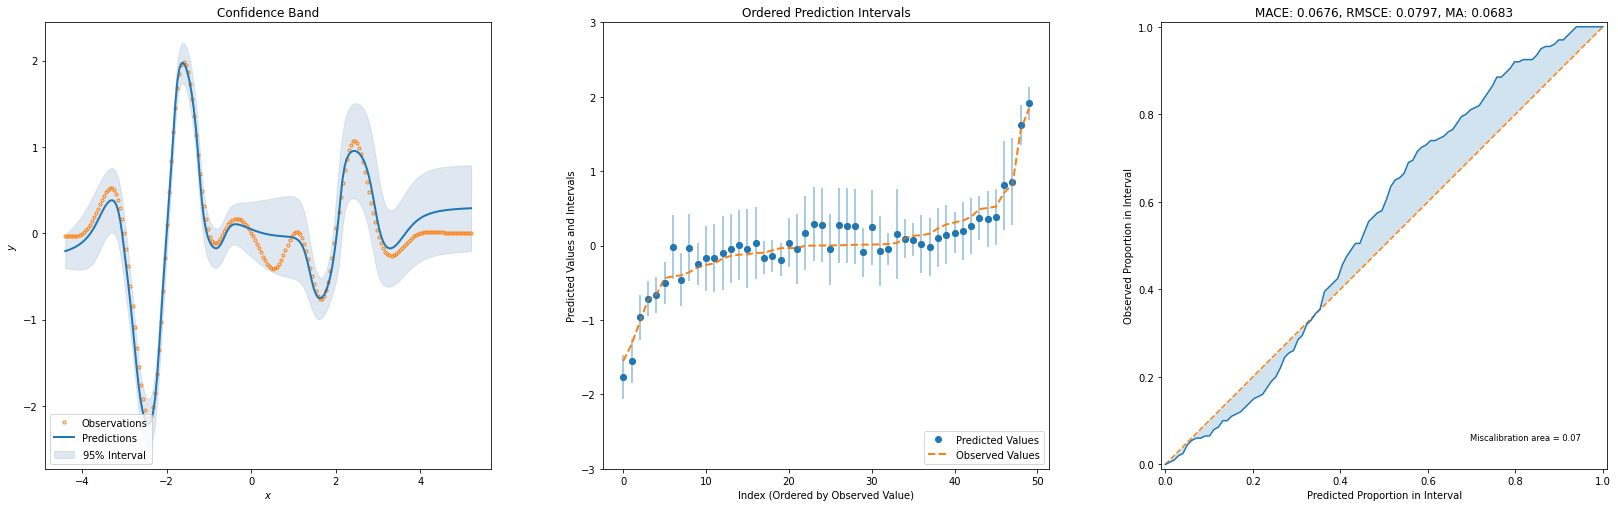

In [ ]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    quantile_median,
    pred_quantiles=quantile_cp_sets,
    aleatoric=cp_qr_model_std,
    title=f"Conformal Prediction on Quantile Regression: Coverage {compute_empirical_coverage(quantile_cp_sets, y_test_cpu)}",
)
plot_calibration_uq_toolbox(cp_qr_model_mean, cp_qr_model_std, y_test_cpu, X_test_cpu)

### Conformal Prediction on MC-Dropout



**_Experiments:_** Here are some suggestions that you can try to observe possible changes on the predictive uncertainty.
- observe changes to the predictive uncertainty and calibration before and after conformal prediction

In [ ]:
mc_quantiles_nll = compute_quantiles_from_std(mc_mean_nll, mc_std_nll, quantiles)

# conformalize quantile scores
mc_quantiles_conformalized = conformalize_scores(mc_quantiles_nll, y_test_cpu, mc_quantiles_nll, quantiles)

cp_mc_model_mean, cp_mc_model_std = compute_sample_mean_std_from_quantile(mc_quantiles_conformalized, quantiles)

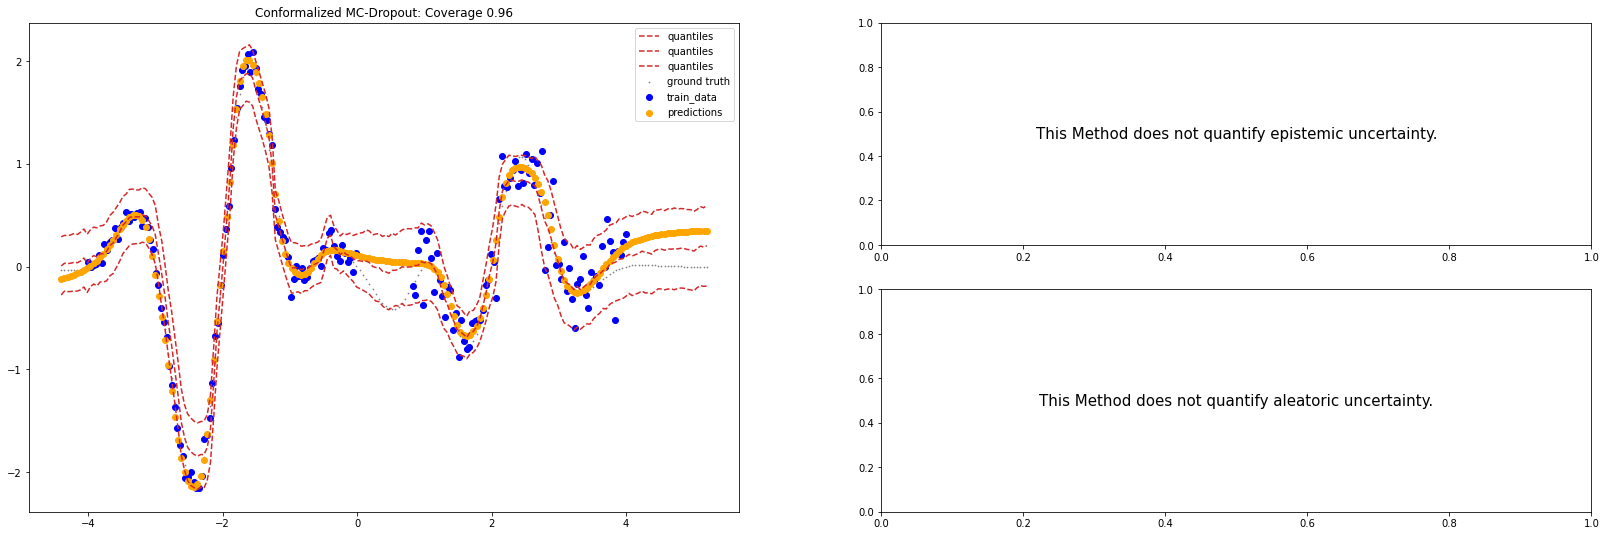

<Figure size 2016x648 with 0 Axes>

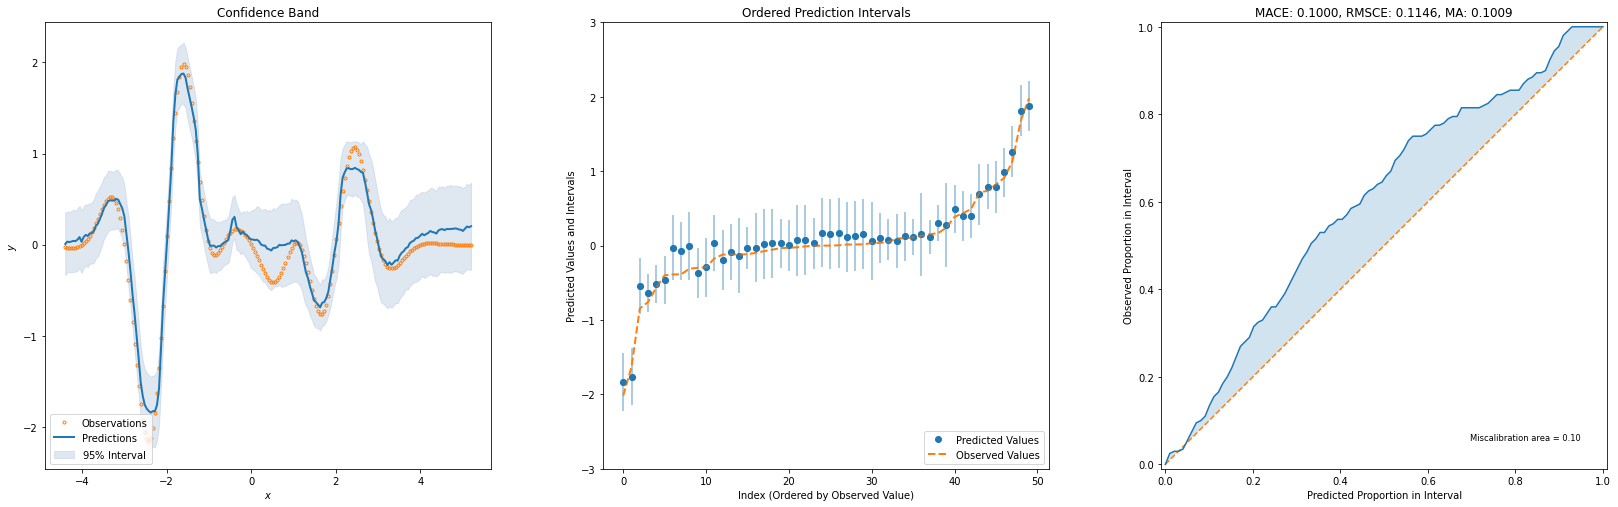

In [ ]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    quantile_median,
    pred_quantiles=mc_quantiles_conformalized,
    title=f"Conformalized MC-Dropout: Coverage {compute_empirical_coverage(mc_quantiles_conformalized, y_test_cpu)}",
)
plot_calibration_uq_toolbox(cp_mc_model_mean, cp_mc_model_std, y_test_cpu, X_test_cpu)

# Quantitative Comparison

Compute UQ metrics across methods.

In [ ]:
def generate_metrics(results, test_targets):
    """Generate metrics"""
    metrics_to_viz = []
    metrics_dict = {}
    for model, output in results.items():
        try:
          uq_metrics = uct.metrics.get_all_metrics(
              output["mean"].squeeze(), output["std"].squeeze(), test_targets.squeeze(), verbose=False
          )
        except:
          print(output["mean"].shape, output["std"].shape)
        metrics_dict[model] = {
            "scoring_rule": uq_metrics["scoring_rule"],
            "calibration": uq_metrics["avg_calibration"],
            "sharpness": uq_metrics["sharpness"],
            "accuracy": uq_metrics["accuracy"]
        }

    keys = ["scoring_rule", "calibration", "sharpness", "accuracy"]
    new_dict = {k: {method: metric[k] for method, metric in metrics_dict.items()} for k in keys}
    return new_dict

def visualize_metrics(metric_df: pd.DataFrame, metric_group: str):
  """Visualize metric group."""
  metrics = metric_df[metric_group].columns

  fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize=(len(metrics) * 8, 6))

  for idx, metric in enumerate(metrics):
    labels = metric_df[metric_group].index

    if len(metrics) > 1:
      axs[idx].bar(labels, metric_df[metric_group][metric].values)
      axs[idx].set_title(metric, size=20)
      axs[idx].tick_params(axis="x", labelsize=16, rotation=75)
    else:
      axs.bar(labels, metric_df[metric_group][metric].values)
      axs.set_title(metric, size=20)
      axs.tick_params(axis="x", labelsize=16, rotation=75)


In [ ]:
metrics_dict = generate_metrics(results_dict, y_test_cpu)
metric_df = pd.concat({k: pd.DataFrame(v).T for k, v in metrics_dict.items()}, axis=1)

## Accuracy Metrics

Below a range of accuracy metrics are plotted, to evaluate the different networks on the test set.

* mean absolute error, $mae = \frac{1}{n} \sum_{i=1}^n|f_{\theta}(x_i)-y_i|$. 
* root mean squared error, $rmse = \frac{1}{n} \sum_{i=1}^n|f_{\theta}(x_i)-y_i|^2$.
* median absolute error, $mdae = \text{median}((|f_{\theta}(x_i)-y_i|)_{i=1}^n$
* coefficient of determination, $R^2 = 1 - (\sum_{i=1}^n (y_i - f_{\theta}(x_i))^2)/\sigma_y$ where $\sigma_y = \sum_{i=1}^n(y_i - \bar{y})^2$ and $\bar{y} = \frac{1}{n}\sum_{i=1}^ny_i$
* correlation, $corr = Corr((f(x_i))_{i=1}^n,(y_i)_{i=1}^n)$.

Remarks:

* For mae, rmse, mdae optimal values are near zero.
* For $R^2$ and corr optimal value are near $1$.


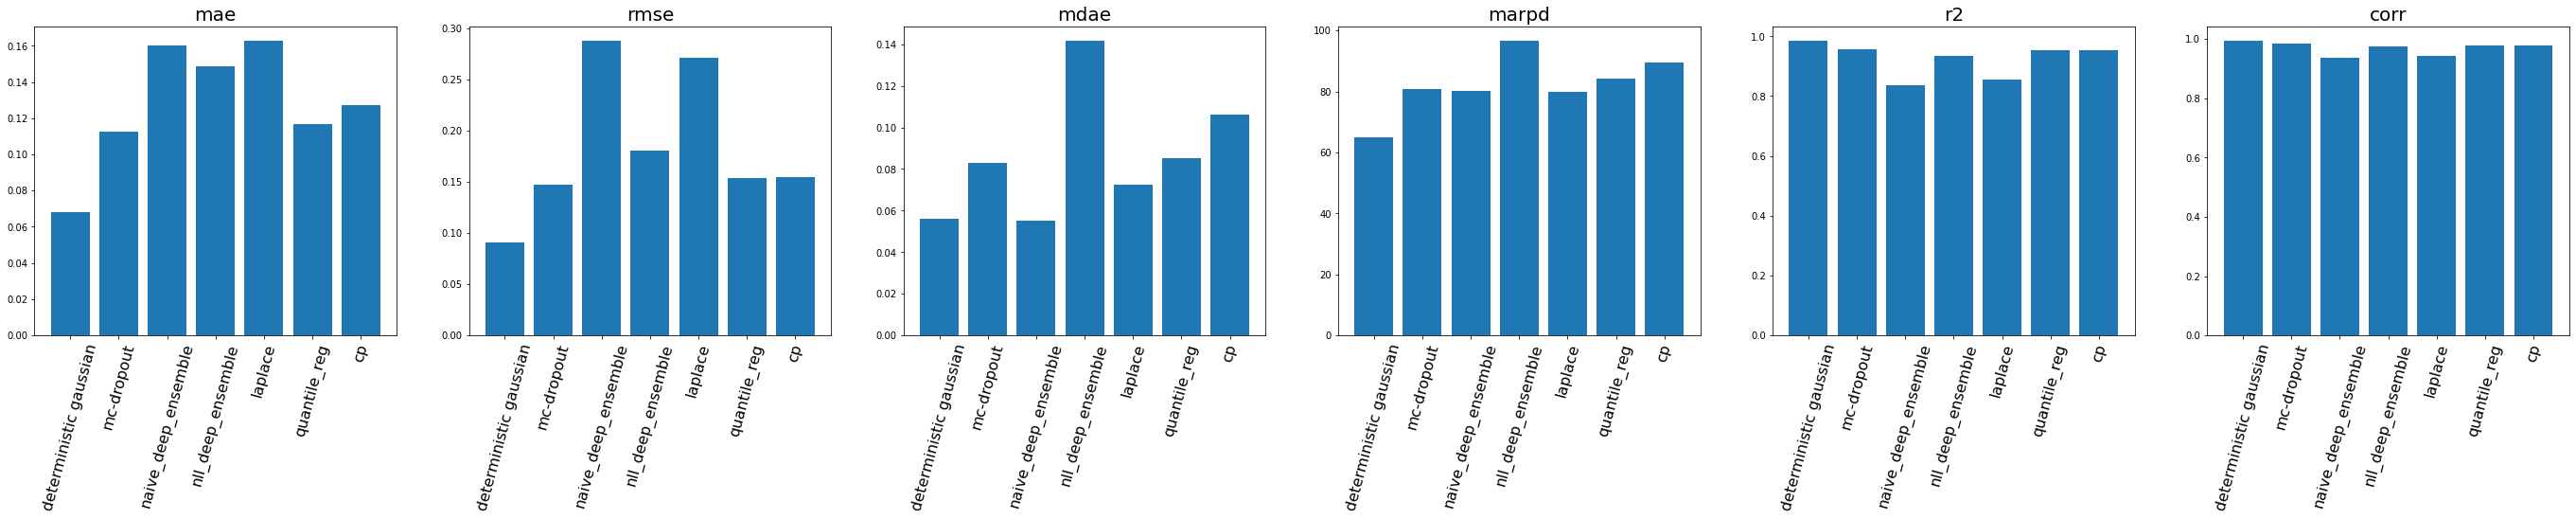

In [ ]:
visualize_metrics(metric_df, "accuracy")

## The importance of Scoring Rules and why Accuracy is not enough

In [ ]:
metric_df

scoring_rule                               calibration  \
                                nll      crps     check  interval     rms_cal   
deterministic gaussian    -0.118145  0.094271  0.047594  0.597465    0.393378   
mc-dropout                 0.238045  0.130643  0.065956  0.806661    0.358841   
naive_deep_ensemble        8.184885  0.142993  0.071802  1.219577    0.301741   
nll_deep_ensemble          0.372038  0.153224  0.077357  0.939811    0.342780   
laplace                   -0.278436  0.118661  0.059913  0.628593    0.212457   
quantile_reg              -0.478364  0.084824  0.042830  0.431626    0.135249   
cp                        -0.475765  0.086814  0.043836  0.427072    0.079668   

                                             sharpness  accuracy            \
                          ma_cal miscal_area     sharp       mae      rmse   
deterministic gaussian  0.347650    0.351162  0.387820  0.067992  0.091152   
mc-dropout              0.319700    0.322929  0.487359  0.112310  0.147311   
naive_deep_ensemble     0.268200    0.270909  0.042626  0.160073  0.287638   
nll_deep_ensemble       0.299250    0.302273  0.576415  0.148419  0.180254   
laplace                 0.186310    0.188187  0.472094  0.162550  0.271374   
quantile_reg            0.118141    0.119310  0.211163  0.116959  0.154049   
cp                      0.067633    0.068306  0.200928  0.127037  0.155009   

                                                                 
                            mdae      marpd        r2      corr  
deterministic gaussian  0.056216  65.037316  0.983568  0.992586  
mc-dropout              0.083085  80.842501  0.957083  0.985593  
naive_deep_ensemble     0.055235  80.171096  0.836376  0.936820  
nll_deep_ensemble       0.141477  96.484637  0.935742  0.974708  
laplace                 0.072367  79.804826  0.854357  0.942933  
quantile_reg            0.085405  84.163070  0.953068  0.979615  
cp                      0.106076  89.461493  0.952481  0.978030

## Scoring Rules

A proper scoring rule is a real-valued
function that takes a predictive distribitution $p_{\theta}(y|x)$ and an event $y_i$ from the true distribution
$q(y|x)$ as inputs and produces a numerical value that is only minimized if the distributions are exactly
equal. In other words, a proper scoring rule attains its optimal score if the predictive distribution matches the ground truth distribution exactly.  In the following we consider negatively oriented scores, meaning that the if the score obtains the minimum the predictive distribution matches the ground truth distribution. In other words, a smaller score means that the predictive distribution matches the true distribution better. For an in depth treatmeant of the used scoring rules see [Strictly Proper Scoring Rules, Prediction,
and Estimation](https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf).

#### Negative Log Likelihood (NLL)

Negative log likelihood for a gaussian probability distribution $p_{\theta}(y|x)$ which is also used as a loss functions in some methods. Note that the probability distribution have values between $0$ and $1$. If given a certain $x$, $p_{\theta}(y|x) \approx 1$, we could almost be certain that our network predicts the label $y$. Thus, we minimize the negative logarithm of the likelihood, as $log(1) = 0$ and $log(a) \to \infty$ for $a \to 0$.

Note that the negative log likelihood also has some disadvantages:
"Commonly used to evaluate the quality of model uncertainty on some held out set. Drawbacks: Although a proper scoring rule ,[Strictly Proper Scoring Rules, Prediction,
and Estimation](https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf), it can over-emphasize tail probabilities, [Evaluating Predictive Uncertainty Challenge](https://quinonero.net/Publications/quinonero06epuc.pdf), [Evaluating
Predictive Uncertainty Under Dataset Shift](https://proceedings.neurips.cc/paper/2019/file/8558cb408c1d76621371888657d2eb1d-Paper.pdf).

#### Continuous Ranked Probability Score (CRPS)
The negatively oriented continuous ranked probability score for Gaussians. Where negatively oriented means a smaller value is more desirable. The negatively oriented crps for a Gaussian $\mathcal{N}(\mu, \sigma)$, which is the distribution used for prediction, and $y$ is the label, is given by,

$crps(\mathcal{N}(\mu, \sigma), y) = -\sigma \big(\frac{y-\mu}{\sigma}(2\Phi(\frac{y-\mu}{\sigma})-1)+2\phi(\frac{y-\mu}{\sigma})-\frac{1}{\sqrt{\pi}}\big),$

where $\Phi$ is the cumulative density function and $\phi$ probability distribution of a Gaussian with mean $0$ and variance $1$. For more details see [Calibrated Probabilistic Forecasting Using Ensemble Model Output Statistics and
Minimum CRPS Estimation](https://sites.stat.washington.edu/MURI/PDF/gneiting2005.pdf)

Then, we compute the average sum over all predictions and labels, where $f_{\theta}(x_i) = (\mu(x_i), \sigma(x_i))$, 

$CRPS = \frac{1}{n} \sum_{i=1}^n crps(f_{\theta}(x_i), y_i).$

For further reading, see for example, [Decomposition of the Continuous Ranked Probability Score for Ensemble Prediction Systems](https://journals.ametsoc.org/view/journals/wefo/15/5/1520-0434_2000_015_0559_dotcrp_2_0_co_2.xml )

The following scoring rules, are scoring rules for quantiles. Note that given a Gaussian distribution, one can compute the corresponding quantiles. For an in depth treatmeant see [Strictly Proper Scoring Rules, Prediction,
and Estimation](https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf).

#### Check Score (Check)
The negatively oriented check score, also known as pinball loss.
In short the check score computes the sum of the differences between a chosen set of quantiles of the predictive distribution and the true labels.

#### Interval Score (Interval)
The negatively oriented interval score.

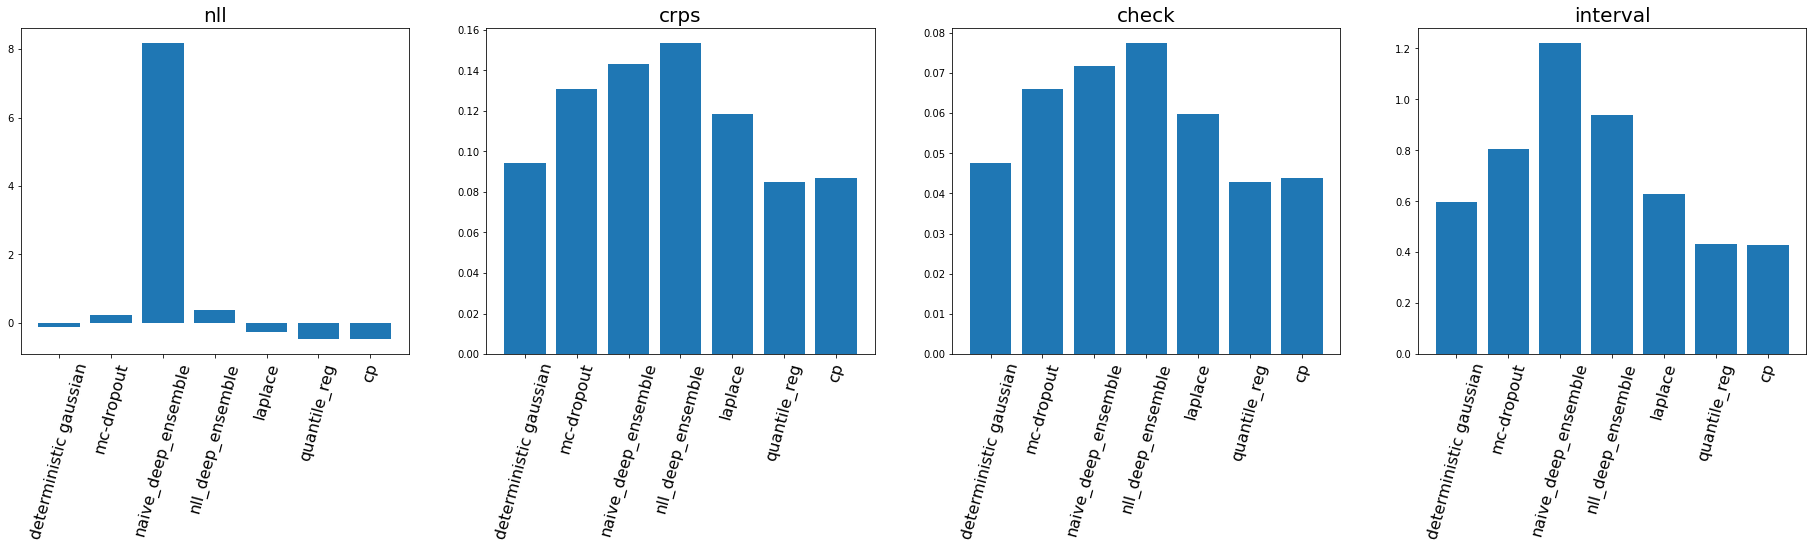

In [ ]:
visualize_metrics(metric_df, "scoring_rule")

## Calibration

Calibration refers to the degree to which a predicted distribution matches the true underlying distribution of the data. Recall that for regression, our neural network either outputs quantiles given an input $x$ or a mean and variance of a probability distribution, which can be converted to quantiles.

Formally, [Accurate Uncertainties for Deep Learning Using Calibrated Regression](https://proceedings.mlr.press/v80/kuleshov18a/kuleshov18a.pdf), one can say that our model's predictions are well calibrated if

$\frac{1}{n}\sum_{i=1}^n \mathbb{I}(y_i \leq F^{-1}_i(p)) \to p$ for all $p \in [0,1]$, as the number of data points $n \to \infty$.

Here $\mathbb{I}(y_i \leq F^{-1}_i(p)) = 1$ if $y_i \leq F^{-1}_i(p)$ and zero otherwise. Moreover, $F_i(y) := P(Y \leq y \vert x_i) \in [0,1]$ and $F^{-1}_i(p) = \inf \{ y \in \mathbb{R}: p \leq F_i(y) \}$ denotes the quantile function.

In simpler words, the empirical and the predicted
cumulative distribution functions should match, as the dataset size goes to infinity.

 Below we plot a range of calibration metrics.



*   Root-mean-squared Calibration Error, rms_cal, gives the root mean squared error of the expected and observed proportions for a given range of quantiles. 
*   Mean-absolute Calibration Error,  ma_cal, gives the mean absolute error of the expected and observed proportions for a given range of quantiles.
*   Miscalibration Area, miscal_area, if the number of quantiles is the same this is just mean absolute calibration error. Otherwise as the number of quantiles increases this describes area between the curves of predicted and empirical quantiles.

Remarks:

For all calibration metrics a lower value indicates a better calibration of our model.

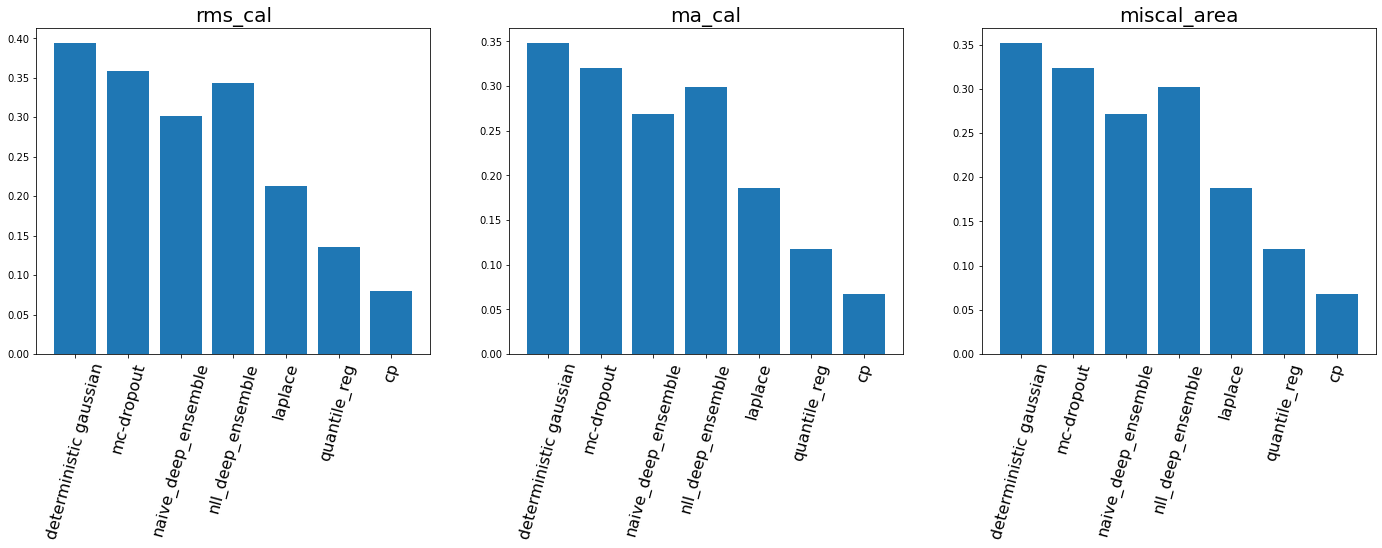

In [ ]:
visualize_metrics(metric_df, "calibration")

## Sharpness

Sharpness captures how concentrated the predictive distribution is around its mean and is a property of the predictive distribution only, meaning that it doesn not depend on the ground truth observations. 

Below a sharpness metric is computed, it returns single scalar which quantifies the average of the standard deviations predicted by our model, $\sigma_{\theta}$.

It is given by,

sharp $= \sqrt{\frac{1}{n} \sum_{i=1}^n \sigma_{\theta}(x_i)^2}.$

Note, that this metric does not compare the empirical variance of the labels, but only yields a measure on our predictive uncertainties.

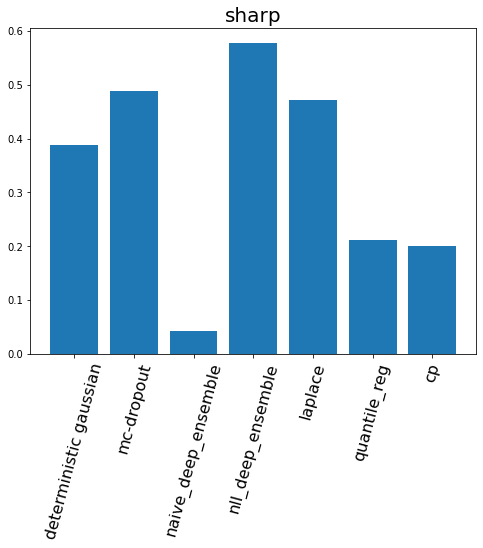

In [ ]:
visualize_metrics(metric_df, "sharpness")